<img style="float: left" src="https://upload.wikimedia.org/wikipedia/commons/d/db/Logo_ITESO_normal.jpg" width ="110px"/>


 # <p style="text-align: center">  <font color = 'darkblue'> PAP - Predicción de consumo de energía en días festivos

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
#from xlrd.xldate import xldate_as_tuple
import numpy as np
from datetime import datetime
from calendar import monthrange
import scipy as sp
from pandas import Series
from numpy import polynomial
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sklearn
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm

from pylab import rcParams

# <p style="text-align: center">  <font color = 'darkblue'> Primera Parte
### <p style="text-align: center">  <font color = 'black'> Pruebas Estadísticas

In [2]:
# Acomodo de datos
df = pd.read_excel("datos.xlsx") #leyendo los datos
df = df.set_index("fecha") #establece la fecha como el index

dates = pd.read_csv("fechas.csv")
dates['Fecha'] = pd.to_datetime(dates['Fecha']) 
dates = dates.set_index("Fecha")

names = ['año nuevo','aniversario de la Constitución de 1917','natalicio de Benito Juárez Garcia',
        'jueves santo','viernes santo','día del trabajo',
        'día de la madre','día de la Independencia',
        'día de la Virgen de Zapopan','día de los muertos',
        'día de la Revolución','día de la Virgen de Guadalupe',
        'Navidad']
data = df.join(dates)
data = data.dropna()

### <font color = 'black'> Representación visual

In [3]:
#Funcion para obtener días anteriores y posteriores

def ant_post(mes):

    consumo_ =pd.DataFrame()
    _consumo =pd.DataFrame()
    consumo = pd.DataFrame()
    
    m = dates.index[mes].month
    nn= monthrange(2002, m)
    n = nn[1]
    
    if dates['Conmemoracion'][mes] == names[mes]:
        month= dates.index.month[mes]
        day = dates.index.day[mes]
    

    for i in range(0,5):
        day_ = day + i    
        z = list(df[(df.index.month == month) & (df.index.day == day_)]['MWh'])
        consumo_[i] = pd.Series(z)
        if day <=(i+1):
            _day = n-(i+1)+day
        else:
            _day = day - i
        y = list(df[(df.index.month == month) & (df.index.day == _day)]['MWh'])
        _consumo[i+5] = pd.Series(y)

    consumo = pd.concat([consumo_ , _consumo],axis=1)
    cols = [ 9, 8, 7, 6 ,5, 1, 2,3, 4, 5]
    consumo = consumo[cols]
    consumo.columns=['-5','-4','-3','-2','-1','Day','+1','+2','+3','+4']
    return(consumo)

#### Gráfica de barras

/Users/aCristy/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


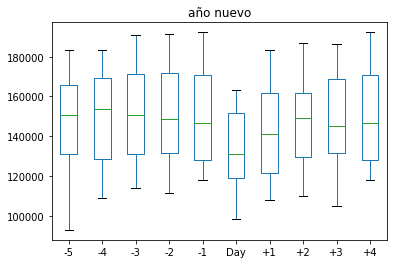

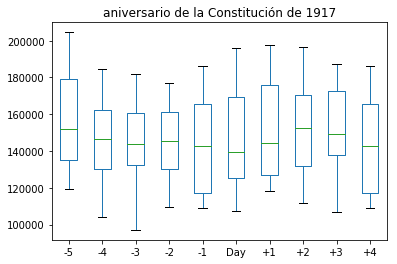

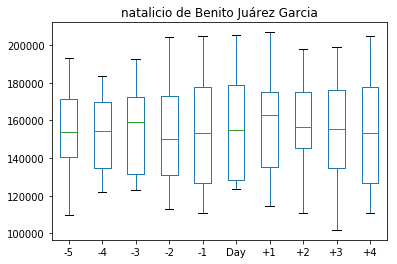

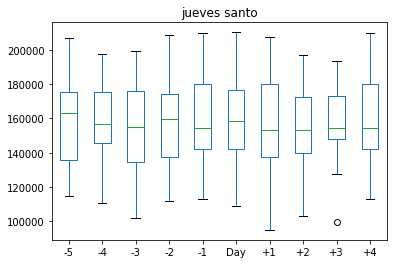

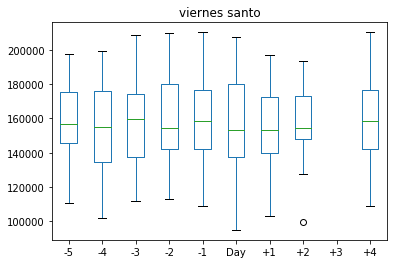

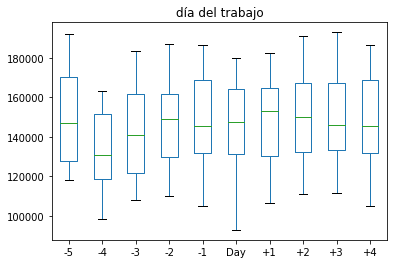

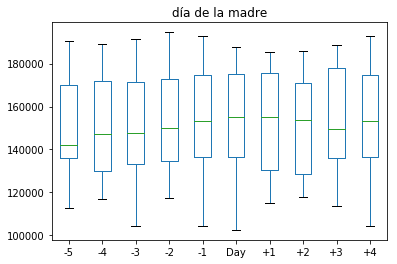

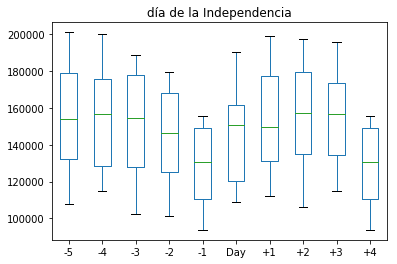

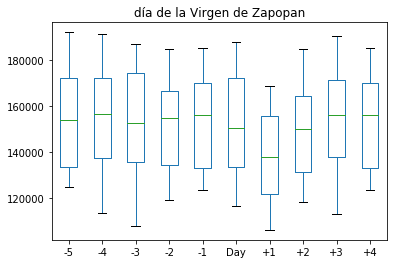

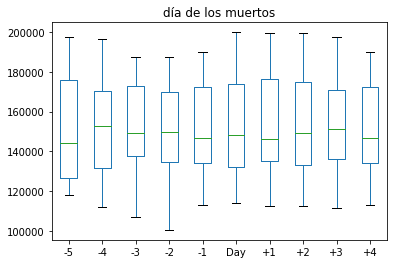

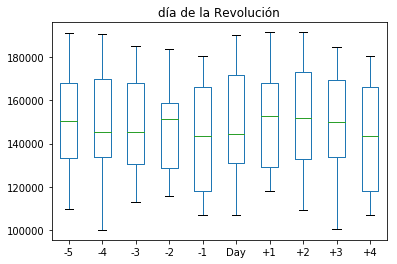

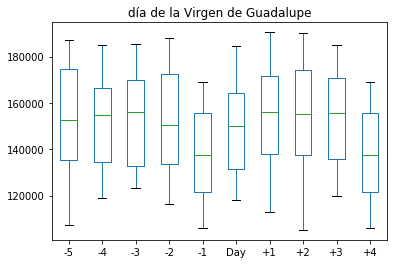

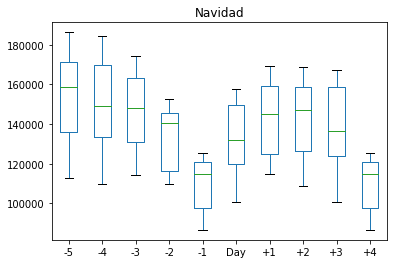

In [4]:
for i in range(len(names)):
    consumo=ant_post(i)
    consumo.plot(kind='box')
    plt.title(names[i])
    

#### Gráfica de Variaciones con respecto al año anterior

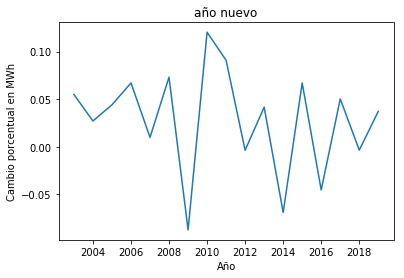

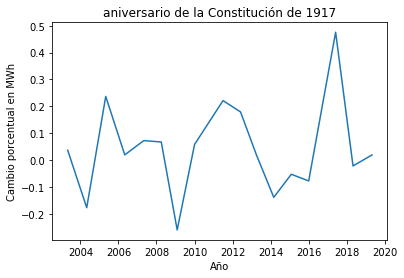

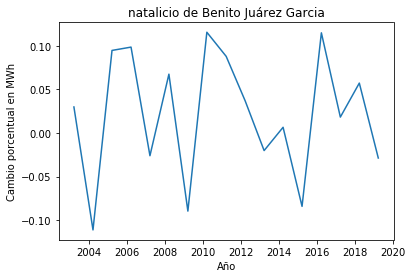

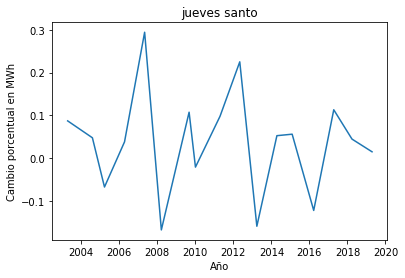

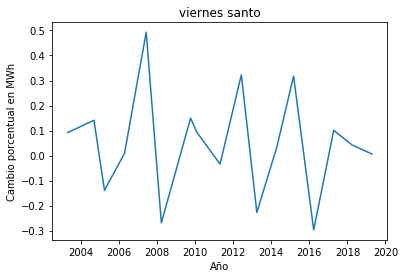

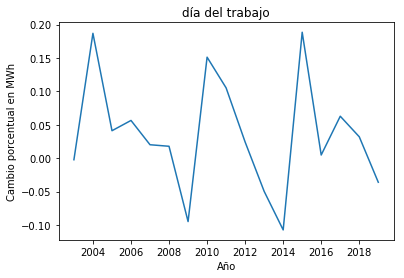

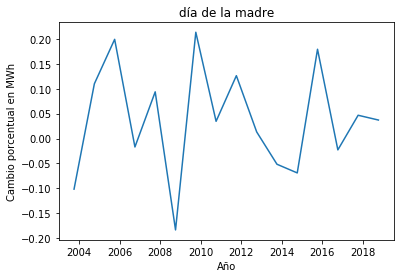

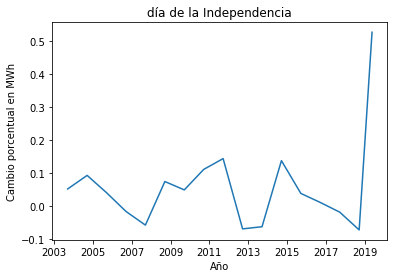

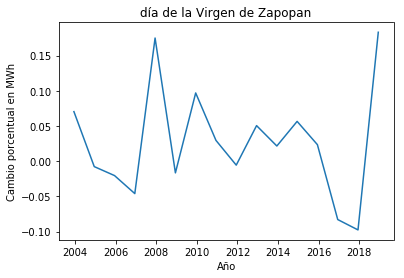

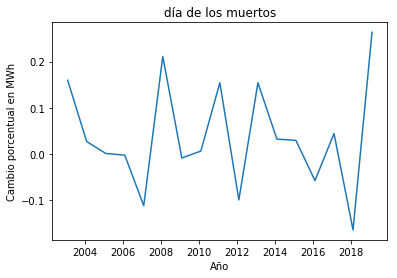

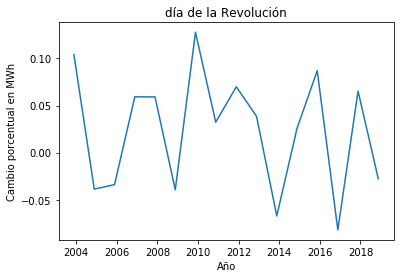

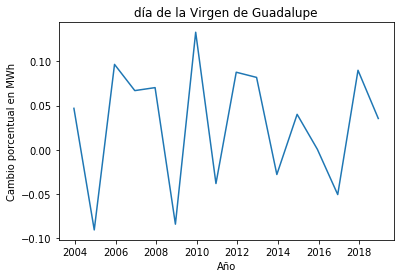

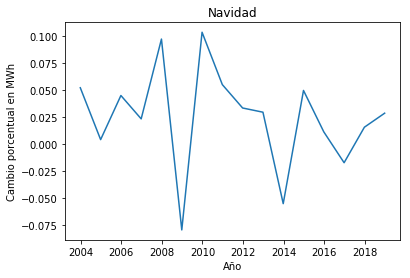

In [80]:
# Calcular variaciones (año con año)
for i in range(len(names)):
    change = data[(data.Conmemoracion==names[i])]['MWh'].pct_change().dropna()
    plt.figure(i)
    plt.plot(change)
    plt.title(names[i])
    plt.xlabel('Año')
    plt.ylabel('Cambio porcentual en MWh')


#### Gráfica de Variación con respecto al año anterior

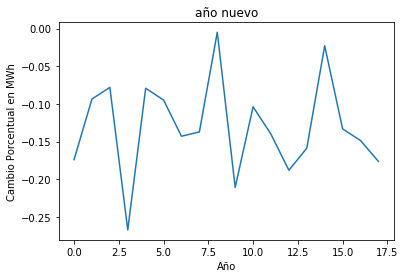

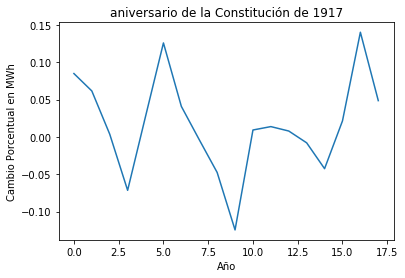

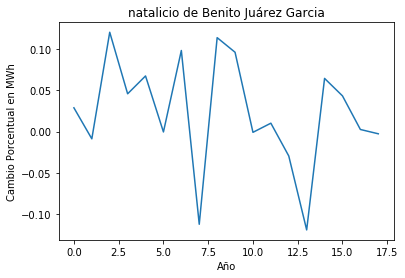

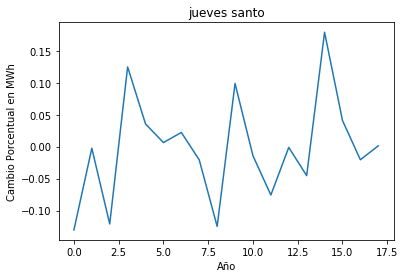

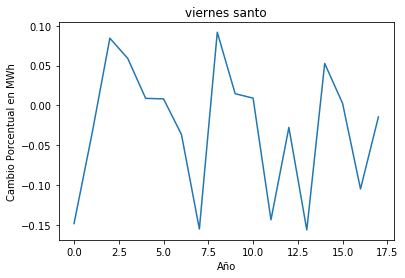

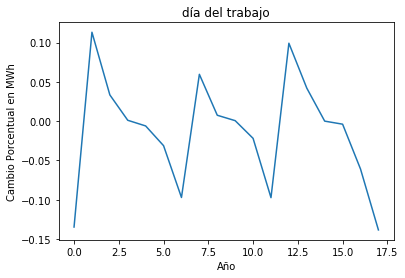

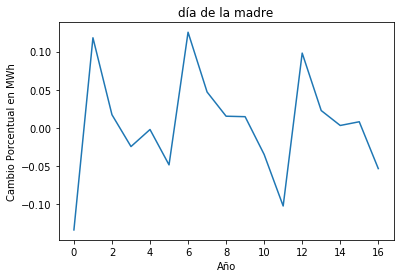

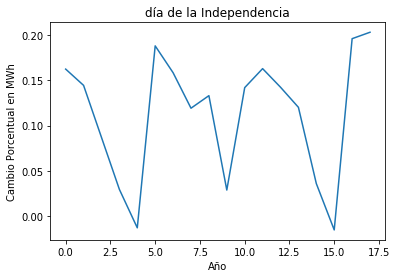

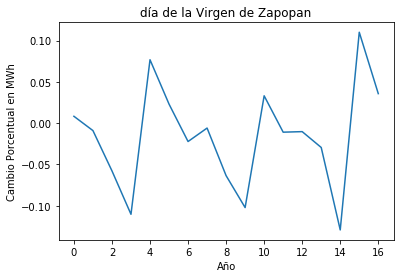

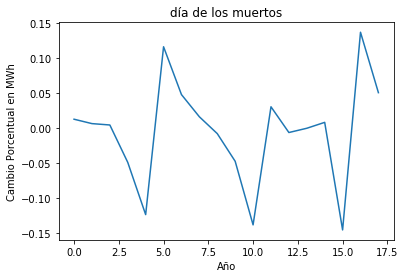

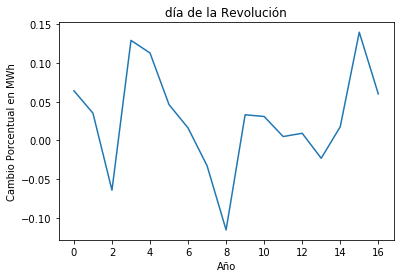

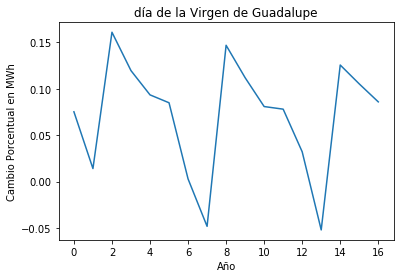

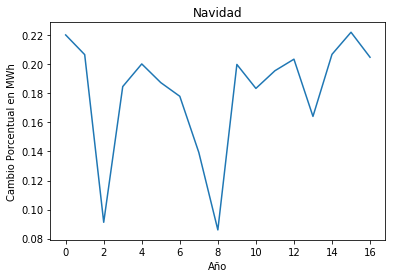

In [5]:
# De un dia a otro

for i in range(len(names)):
    a = ant_post(i)
    a_d1 = (a['Day']-a['-1'])/a['Day']
    plt.figure(i)
    plt.plot(a_d1)
    plt.title(names[i])
    plt.xlabel('Año')
    plt.ylabel('Cambio Porcentual en MWh')

### Pruebas y tendencias

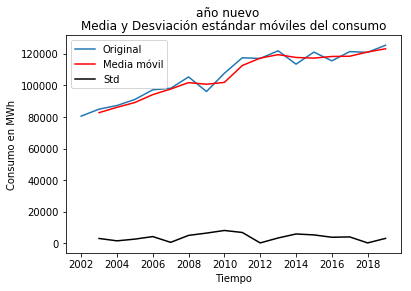

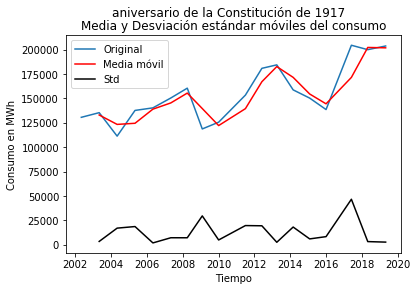

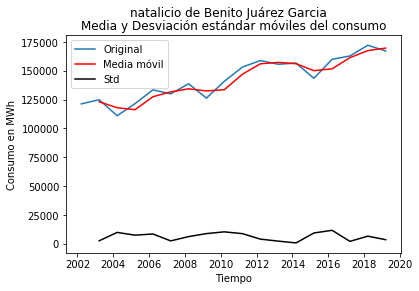

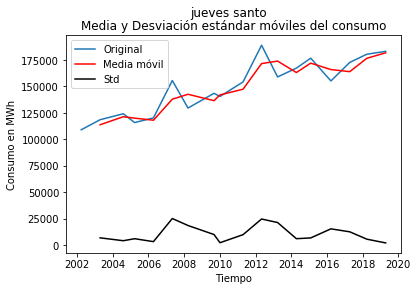

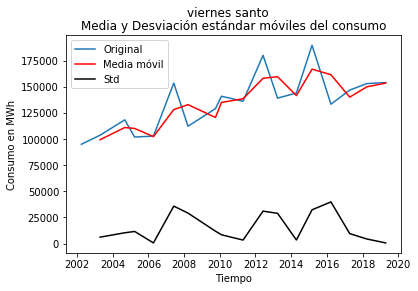

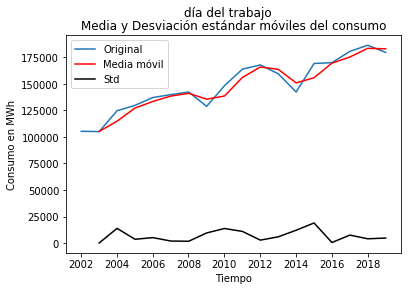

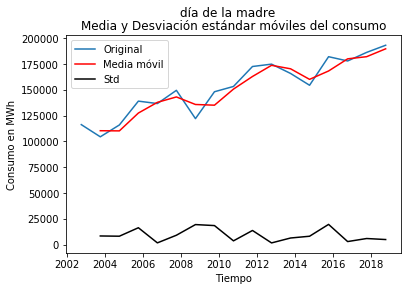

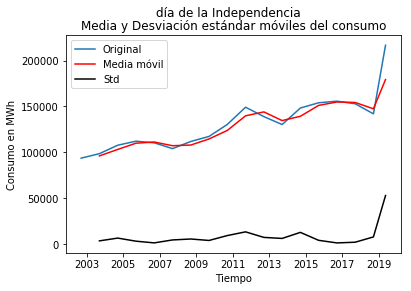

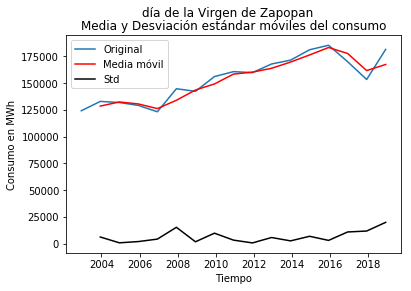

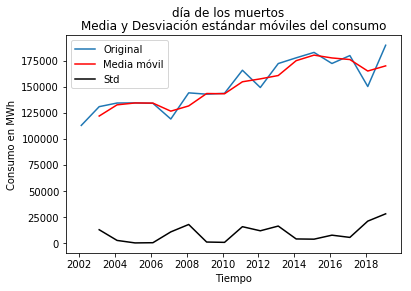

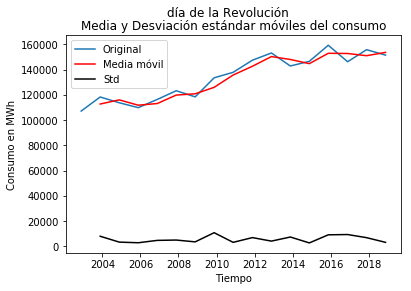

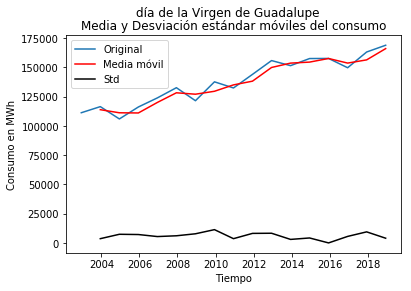

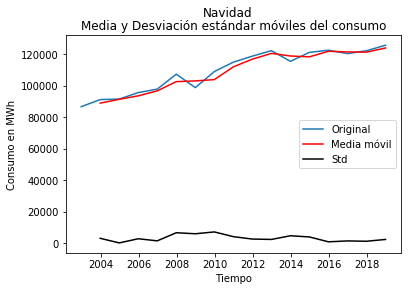

In [6]:
for i in range(len(names)):
    rolling_mean = data[(data.Conmemoracion==names[i])]['MWh'].rolling(window = 2).mean()
    rolling_std = data[(data.Conmemoracion==names[i])]['MWh'].rolling(window = 2).std()
    plt.figure(i)
    plt.plot(data[(data.Conmemoracion==names[i])]['MWh'], label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Media móvil')
    plt.plot(rolling_std, color = 'black', label = 'Std')
    plt.legend(loc = 'best')
    plt.title('Media y Desviación estándar móviles del consumo')
    plt.suptitle(names[i])
    plt.ylabel('Consumo en MWh')
    plt.xlabel('Tiempo')
    plt.show()

In [7]:
#PRUEBA DICKEY FULLER PARA ESTACIONARIEDAD

for i in range(len(names)):
    result = adfuller(data[(data.Conmemoracion==names[i])]['MWh'].dropna())
    print('Resultados de',names[i],':')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    print('-------------------------------------------')

Resultados de año nuevo :
ADF Statistic: 0.0
p-value: 0.958532086060056
Critical Values:
	1%: -4.473135048010974
	5%: -3.28988060356653
	10%: -2.7723823456790124
-------------------------------------------
Resultados de aniversario de la Constitución de 1917 :
ADF Statistic: -0.07374319202876141
p-value: 0.9519918222880315
Critical Values:
	1%: -4.331573
	5%: -3.23295
	10%: -2.7487
-------------------------------------------
Resultados de natalicio de Benito Juárez Garcia :
ADF Statistic: -0.0
p-value: 0.958532086060056
Critical Values:
	1%: -4.473135048010974
	5%: -3.28988060356653
	10%: -2.7723823456790124
-------------------------------------------
Resultados de jueves santo :
ADF Statistic: -0.6444537691375299
p-value: 0.8606176757312339
Critical Values:
	1%: -4.331573
	5%: -3.23295
	10%: -2.7487
-------------------------------------------
Resultados de viernes santo :
ADF Statistic: -1.057087448023829
p-value: 0.7318782061188752
Critical Values:
	1%: -4.331573
	5%: -3.23295
	10%: 

/Users/aCristy/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


# <p style="text-align: center">  <font color = 'darkblue'> Segunda Parte
### <p style="text-align: center">  <font color = 'black'> Proyecciones

In [8]:
# librerias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import matplotlib.gridspec as gridspec
import itertools

### Acomodo de base de datos

In [9]:
comp = pd.read_excel('Consumo GCROC 2002-2019-2.xlsx', 'datos' ,usecols='B:J')
comp.columns = ['MWh', 'Temp min', 'Temp max', 'Temp prom',
               'borrar','borrar1','Vel viento', 'dia sem']
comp =comp.drop(['borrar','borrar1'], axis =1)
comp =comp.drop('fecha',axis = 0)

In [10]:
def ant_one(mes):
    consumo_ =pd.DataFrame()
    m = dates.index[mes].month
    nn= monthrange(2002, m)
    n = nn[1]
    if dates['Conmemoracion'][mes] == names[mes]:
        month= dates.index.month[mes]
        day = dates.index.day[mes]
    if day <=1:
            _day = n
    else:
            _day = day - 1
    z = list(df[(df.index.month == month) & (df.index.day == _day)]['MWh'])
    consumo_= pd.Series(z)
    
    return consumo_

fechas_comp = comp.join(dates).dropna()

###  <p style="text-align: center">  <font color = 'blue'>Regresión linear

In [11]:
def reg_1v(df):
    X = df.iloc[0:14,5]
    Y = df.iloc[0:14,0]
    test = np.reshape(X.iloc[-1],1)
    print(test)
    print("\n")
    X = np.reshape(np.asarray(X), (len(X), 1))
    test_size = 0.20
    n=round(len(X)*(1-test_size))
    X_train = X[0:n,:]
    Y_train = Y[0:n]
    X_test =  X[n:len(X),:]
    Y_test = Y[n:len(X)]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict([X_test[0],X_test[1],X_test[2]])
    print('prediccion: ', Y_pred)
    print("\n")
    print('real: ', Y[n:len(Y)])
    print("\n")
    print('Coefficients: \n', lr.coef_)
    print("\n")
    print('Intercept: \n', lr.intercept_)
    print("\n")
    X = sm.add_constant(X)
    Y_train = list(Y_train)
    temporal = np.asarray(X_train)
    X_train = temporal.tolist() 

 

    temporal2 = np.asarray(X_test)
    X_test = temporal2.tolist()

 

    model0 = sm.OLS(Y_train, X_train).fit()
    predictions0 = model0.predict([X_test]) 
    print(predictions0)
    print("\n")
    
    real = Y[-1]
    error = (predictions0-real)/real*100
    print("error: ", error)
    print("\n")
    print_model0 = model0.summary()
    print(print_model0)

In [23]:
def reg_av(df):
    X = df.iloc[0:14,1:6]
    Y = df.iloc[0:14,0]
    test = np.reshape(X.iloc[-1],5)
    print(test)
    X = np.reshape(X,(len(X),5))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)
    lr = linear_model.LinearRegression()
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict([test])
    print('prediccion: ', Y_pred)
    print('real: ', Y[-1])
    print('Coefficients: \n', lr.coef_)
    print('Intercept: \n', lr.intercept_)
    X = sm.add_constant(X)
    Y_train = list(Y_train)
    temporal = np.asarray(X_train)
    X_train = temporal.tolist() 

 

    temporal2 = np.asarray(X_test)
    X_test = temporal2.tolist()

 

    model0 = sm.OLS(Y_train, X_train).fit()
    predictions0 = model0.predict([test]) 
    print(predictions0)
    
    real = Y[-1]
    error = (predictions0-real)/real*100
    print("error: ", error)
    print_model0 = model0.summary()
    print(print_model0)

#### <p style="text-align: center">  <font color = 'red'> Año Nuevo

In [13]:
a_nuevo = fechas_comp[(fechas_comp.Conmemoracion == names[0])].drop(['Conmemoracion','dia sem'], axis =1)
a_nuevo['Dia ant'] = list(ant_one(0))

In [14]:
# Regresión con una sola variable
reg_1v(a_nuevo)

[176255.944]


prediccion:  [121629.141613   120304.04319313 125014.21963826]


real:  2013-01-01    121834
2014-01-01    113393
2015-01-01    120995
Name: MWh, dtype: object


Coefficients: 
 [0.65580021]


Intercept: 
 9425.535242818776


[[123932.9405956  122469.32147438 127671.88168125]]


error:  [[2.42838576 1.21873041 5.5185545 ]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2909.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.16e-13
Time:                        17:37:45   Log-Likelihood:                -110.93
No. Observations:                  11   AIC:                             223.9
Df Residuals:                      10   BIC:                             224.3
Df Model:                 

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [24]:
#Regresión todas las variables
reg_av(a_nuevo)

Temp min      11.5714
Temp max      26.5714
Temp prom     19.0714
Vel viento         27
Dia ant        176256
Name: 2015-01-01 00:00:00, dtype: object
prediccion:  [119668.330394]
real:  120994.722
Coefficients: 
 [ 3.40715532e+03 -2.37952065e+02  1.58460163e+03 -2.32729575e+00
  4.31588918e-01]
Intercept: 
 -19662.489690673945
[118195.69711268114]
error:  [-2.3133446162377678]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1641.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.77e-10
Time:                        17:48:21   Log-Likelihood:                -105.27
No. Observations:                  11   AIC:                             218.5
Df Residuals:                       7   BIC:                      

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Aniversario de la Constitución de 1917

In [39]:
a_const = fechas_comp[(fechas_comp.Conmemoracion == names[1])].drop(['Conmemoracion','dia sem'], axis =1)
a_const['Dia ant'] = list(ant_one(1))

In [52]:
reg_1v(a_const)

[176774.83]


prediccion:  [148716.06469242 156877.77748529 161504.40286436]


real:  2013-04-02    184366
2014-03-02    158730
2015-02-02    150294
Name: MWh, dtype: object


Coefficients: 
 [0.48544363]


Intercept: 
 75690.18755701711


[[157461.16890477 175059.76391033 185035.86921504]]


error:  [[ 4.76885087 16.47830653 23.11603884]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     521.6
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           5.84e-10
Time:                        18:01:31   Log-Likelihood:                -124.23
No. Observations:                  11   AIC:                             250.5
Df Residuals:                      10   BIC:                             250.9
Df Model:               

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [64]:
reg_av(a_const)

Temp min      13.0714
Temp max      21.5714
Temp prom     17.3214
Vel viento         27
Dia ant        176775
Name: 2015-02-02 00:00:00, dtype: object
prediccion:  [125950.24621395]
real:  150293.878
Coefficients: 
 [2.04245842e+02 4.13307968e+03 2.16866276e+03 2.56689126e+03
 5.51075392e-01]
Intercept: 
 -170162.6316066645
[137094.86036564267]
error:  [-8.782139239468775]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     180.0
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           3.92e-07
Time:                        18:04:13   Log-Likelihood:                -121.07
No. Observations:                  11   AIC:                             250.1
Df Residuals:                       7   BIC:                           

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Natalicio de Benito Juárez Garcia

In [40]:
nat_bj = fechas_comp[(fechas_comp.Conmemoracion == names[2])].drop(['Conmemoracion','dia sem'], axis =1)
nat_bj['Dia ant'] = list(ant_one(2))

In [53]:
reg_1v(nat_bj)

[172107.086]


prediccion:  [158032.60586438 161853.48643784 152981.41786016]


real:  2013-03-18    155634
2014-03-17    156639
2015-03-16    143449
Name: MWh, dtype: object


Coefficients: 
 [0.62930135]


Intercept: 
 44674.19564761236


[[170134.20842484 175868.78507079 162553.12228346]]


error:  [[18.60219924 22.59982798 13.3173509 ]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1607.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           2.23e-12
Time:                        18:01:41   Log-Likelihood:                -117.45
No. Observations:                  11   AIC:                             236.9
Df Residuals:                      10   BIC:                             237.3
Df Model:              

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [65]:
reg_av(nat_bj)

Temp min        12.5
Temp max          18
Temp prom      15.25
Vel viento        28
Dia ant       172107
Name: 2015-03-16 00:00:00, dtype: object
prediccion:  [144043.49189297]
real:  143449.455
Coefficients: 
 [-1.48188071e+02  8.24651966e+02  3.38231947e+02  9.60265179e+02
  5.82589402e-01]
Intercept: 
 -1261.1190622519352
[144166.05274640827]
error:  [0.49954720734790004]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     604.7
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           5.80e-09
Time:                        18:04:29   Log-Likelihood:                -113.89
No. Observations:                  11   AIC:                             235.8
Df Residuals:                       7   BIC:                         

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Jueves Santo

In [41]:
js = fechas_comp[(fechas_comp.Conmemoracion == names[3])].drop(['Conmemoracion','dia sem'], axis =1)
js['Dia ant'] = list(ant_one(3))

In [54]:
reg_1v(js)

[177289.361]


prediccion:  [164396.13399141 175973.31150829 166739.94534811]


real:  2013-03-28    159013
2014-04-17    167382
2015-02-04    176775
Name: MWh, dtype: object


Coefficients: 
 [0.94170572]


Intercept: 
 -214.45930170238717


[[164356.68374471 175916.00362645 166696.87980502]]


error:  [[-7.02483847 -0.48583069 -5.70100969]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1134.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.26e-11
Time:                        18:01:48   Log-Likelihood:                -119.74
No. Observations:                  11   AIC:                             241.5
Df Residuals:                      10   BIC:                             241.9
Df Model:            

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [66]:
reg_av(js)

Temp min      10.4286
Temp max      24.8571
Temp prom     17.6429
Vel viento         27
Dia ant        177289
Name: 2015-02-04 00:00:00, dtype: object
prediccion:  [165798.83460585]
real:  176774.83
Coefficients: 
 [-2.93456956e+01 -2.65956632e+02 -1.47651164e+02 -1.09515328e+03
  9.40052003e-01]
Intercept: 
 38228.69833157945
[163242.22789013135]
error:  [-7.655276551457373]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     418.5
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           2.09e-08
Time:                        18:04:41   Log-Likelihood:                -116.06
No. Observations:                  11   AIC:                             240.1
Df Residuals:                       7   BIC:                        

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Viernes Santo

In [42]:
vs = fechas_comp[(fechas_comp.Conmemoracion == names[4])].drop(['Conmemoracion','dia sem'], axis =1)
vs['Dia ant'] = list(ant_one(4))

In [55]:
reg_1v(vs)

[178946.184]


prediccion:  [155817.7025119  175249.53520388 165103.91420218]


real:  2013-03-29    139054
2014-04-18    143945
2015-03-04    189617
Name: MWh, dtype: object


Coefficients: 
 [1.17691028]


Intercept: 
 -45499.68985345212


[[148335.85175629 162653.72772161 155178.17225568]]


error:  [[-21.77084963 -14.21990859 -18.16235639]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     745.6
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.00e-10
Time:                        18:01:55   Log-Likelihood:                -121.12
No. Observations:                  11   AIC:                             244.2
Df Residuals:                      10   BIC:                             244.6
Df Model:          

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [67]:
reg_av(vs)

Temp min         12.5
Temp max      28.8571
Temp prom     20.6786
Vel viento         27
Dia ant        178946
Name: 2015-03-04 00:00:00, dtype: object
prediccion:  [188155.40255347]
real:  189617.107
Coefficients: 
 [-1.40115489e+03  3.01591353e+02 -5.49781768e+02 -4.66724411e+03
  1.73244259e+00]
Intercept: 
 24337.07626145915
[186667.5235845301]
error:  [-1.5555471033897181]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     293.9
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           7.15e-08
Time:                        18:04:49   Log-Likelihood:                -117.64
No. Observations:                  11   AIC:                             243.3
Df Residuals:                       7   BIC:                       

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Día del trabajo

In [43]:
dt = fechas_comp[(fechas_comp.Conmemoracion == names[5])].drop(['Conmemoracion','dia sem'], axis =1)
dt['Dia ant'] = list(ant_one(5))

In [56]:
reg_1v(dt)

[151670.946]


prediccion:  [163970.94872675 156523.1186899  153260.88891246]


real:  2013-01-05    159502
2014-01-05    142356
2015-01-05    169182
Name: MWh, dtype: object


Coefficients: 
 [0.9711552]


Intercept: 
 5964.860629474744


[[165129.20277772 157345.61512475 153936.31989497]]


error:  [[-2.39569526 -6.99640579 -9.01156655]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4128.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           2.03e-14
Time:                        18:02:03   Log-Likelihood:                -112.58
No. Observations:                  11   AIC:                             227.2
Df Residuals:                      10   BIC:                             227.6
Df Model:               

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [68]:
reg_av(dt)

Temp min      11.1429
Temp max      21.8571
Temp prom        16.5
Vel viento         27
Dia ant        151671
Name: 2015-01-05 00:00:00, dtype: object
prediccion:  [147740.31576875]
real:  169182.295
Coefficients: 
 [-288.7624371   880.99499465  296.11627878  145.61676711    0.97090012]
Intercept: 
 -24372.990803448978
[148821.9852638894]
error:  [-12.034539273811493]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     844.0
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.81e-09
Time:                        18:04:56   Log-Likelihood:                -111.98
No. Observations:                  11   AIC:                             232.0
Df Residuals:                       7   BIC:                             233

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Día de la madre

In [44]:
d_madre = fechas_comp[(fechas_comp.Conmemoracion == names[6])].drop(['Conmemoracion','dia sem'], axis =1)
d_madre['Dia ant'] = list(ant_one(6))

In [57]:
reg_1v(d_madre)

[163463.841]


prediccion:  [171531.94974291 176017.96961883 165585.02837441]


real:  2013-10-05    165759
2014-10-05    154318
2015-10-05    181982
Name: MWh, dtype: object


Coefficients: 
 [1.11147998]


Intercept: 
 -16101.757589478279


[[168521.98589877 172551.07528265 163180.7974031 ]]


error:  [[ -7.39625307  -5.18224656 -10.33126517]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2957.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.07e-13
Time:                        18:02:12   Log-Likelihood:                -114.72
No. Observations:                  11   AIC:                             231.4
Df Residuals:                      10   BIC:                             231.8
Df Model:         

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [70]:
reg_av(d_madre)

Temp min      16.9286
Temp max         28.5
Temp prom     22.7143
Vel viento      23.25
Dia ant        163464
Name: 2015-10-05 00:00:00, dtype: object
prediccion:  [170410.03345458]
real:  181981.822
Coefficients: 
 [ 1.89474134e+03  1.06408710e+03  1.47941422e+03 -3.40336049e+02
  1.18432638e+00]
Intercept: 
 -111277.27610155562
[169646.20473774642]
error:  [-6.778488712050354]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     446.0
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.67e-08
Time:                        18:05:08   Log-Likelihood:                -115.73
No. Observations:                  11   AIC:                             239.5
Df Residuals:                       7   BIC:                     

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Día de la Independencia

In [45]:
d_ind = fechas_comp[(fechas_comp.Conmemoracion == names[7])].drop(['Conmemoracion','dia sem'], axis =1)
d_ind['Dia ant'] = list(ant_one(7))

In [58]:
reg_1v(d_ind)

[178834.969]


prediccion:  [123227.04743525 135951.93078287 152349.68263699]


real:  2013-09-16    130330
2014-09-16    148317
2015-09-16    154054
Name: MWh, dtype: object


Coefficients: 
 [0.77965524]


Intercept: 
 12920.06225509246


[[123826.08815445 138110.51923181 156517.9615466 ]]


error:  [[-19.62159996 -10.34924279   1.59945706]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     9668.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           2.90e-16
Time:                        18:02:22   Log-Likelihood:                -106.16
No. Observations:                  11   AIC:                             214.3
Df Residuals:                      10   BIC:                             214.7
Df Model:           

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [71]:
reg_av(d_ind)

Temp min          18
Temp max        28.5
Temp prom      23.25
Vel viento     23.25
Dia ant       178835
Name: 2015-09-16 00:00:00, dtype: object
prediccion:  [155664.238864]
real:  154053.935
Coefficients: 
 [  71.65389421 -687.51719535 -307.93165057  122.76840769    0.82730614]
Intercept: 
 30322.486143418122
[155524.4154555523]
error:  [0.9545231386347355]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1380.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           3.25e-10
Time:                        18:05:17   Log-Likelihood:                -108.13
No. Observations:                  11   AIC:                             224.3
Df Residuals:                       7   BIC:                             225.9
Df Mod

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Zapopan

In [46]:
d_vz = fechas_comp[(fechas_comp.Conmemoracion == names[8])].drop(['Conmemoracion','dia sem'], axis =1)
d_vz['Dia ant'] = list(ant_one(8))

In [59]:
reg_1v(d_vz)

[184892.605]


prediccion:  [164571.05489725 178905.59100481 182232.13848676]


real:  2013-12-10    171468
2014-12-10    181147
2015-12-10    185388
Name: MWh, dtype: object


Coefficients: 
 [0.8976893]


Intercept: 
 16256.025723433893


[[167149.62838434 183304.51435098 187053.50174967]]


error:  [[-9.8379622  -1.12386901  0.89836907]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2832.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.33e-13
Time:                        18:02:31   Log-Likelihood:                -115.17
No. Observations:                  11   AIC:                             232.3
Df Residuals:                      10   BIC:                             232.7
Df Model:              

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [72]:
reg_av(d_vz)

Temp min           13
Temp max      26.6429
Temp prom     19.8214
Vel viento      23.25
Dia ant        184893
Name: 2015-12-10 00:00:00, dtype: object
prediccion:  [178365.29270296]
real:  185388.033
Coefficients: 
 [ 7.77878390e+02 -4.10910595e+02  1.83483898e+02  2.09101729e+03
  8.56626208e-01]
Intercept: 
 -31436.210129382525
[176025.56117802032]
error:  [-5.050202901704922]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1533.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           2.25e-10
Time:                        18:05:28   Log-Likelihood:                -109.64
No. Observations:                  11   AIC:                             227.3
Df Residuals:                       7   BIC:                     

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Día de los muertos

In [47]:
d_muer = fechas_comp[(fechas_comp.Conmemoracion == names[9])].drop(['Conmemoracion','dia sem'], axis =1)
d_muer['Dia ant'] = list(ant_one(9))

In [60]:
reg_1v(d_muer)

[181327.792]


prediccion:  [150383.1804056  162547.26948564 169679.61503426]


real:  2013-02-11    172206
2014-02-11    177699
2015-02-11    182889
Name: MWh, dtype: object


Coefficients: 
 [0.72471388]


Intercept: 
 38268.847751455454


[[154812.19035551 171608.87664512 181457.51963852]]


error:  [[-15.35178349  -6.16769059  -0.78264913]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2669.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.79e-13
Time:                        18:02:40   Log-Likelihood:                -115.05
No. Observations:                  11   AIC:                             232.1
Df Residuals:                      10   BIC:                             232.5
Df Model:          

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [73]:
reg_av(d_muer)

Temp min      11.6905
Temp max      26.5714
Temp prom      19.131
Vel viento         27
Dia ant        181328
Name: 2015-02-11 00:00:00, dtype: object
prediccion:  [178254.83629058]
real:  182888.898
Coefficients: 
 [ 2.37292918e+03  1.24913656e+03  1.81103287e+03 -1.88160712e+03
  8.91780199e-01]
Intercept: 
 -28225.104539262684
[179216.75495855307]
error:  [-2.0078545398895242]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     533.4
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           8.98e-09
Time:                        18:05:35   Log-Likelihood:                -114.93
No. Observations:                  11   AIC:                             237.9
Df Residuals:                       7   BIC:                    

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Día de la Revolución

In [48]:
d_rev = fechas_comp[(fechas_comp.Conmemoracion == names[10])].drop(['Conmemoracion','dia sem'], axis =1)
d_rev['Dia ant'] = list(ant_one(10))

In [61]:
reg_1v(d_rev)

[183812.176]


prediccion:  [147081.27523421 157106.63808141 166220.45331608]


real:  2013-11-18    142870
2014-11-17    146547
2015-11-16    159304
Name: MWh, dtype: object


Coefficients: 
 [0.86056515]


Intercept: 
 8038.1002689682355


[[148455.31616361 159159.3180789  168890.06770007]]


error:  [[-6.81027458 -0.09106085  6.01721408]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3193.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           7.30e-14
Time:                        18:02:47   Log-Likelihood:                -113.08
No. Observations:                  11   AIC:                             228.2
Df Residuals:                      10   BIC:                             228.6
Df Model:             

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [74]:
reg_av(d_rev)

Temp min      15.9286
Temp max      28.4286
Temp prom     22.1786
Vel viento      23.25
Dia ant        183812
Name: 2015-11-16 00:00:00, dtype: object
prediccion:  [167861.20357539]
real:  159304.382
Coefficients: 
 [ 3.28769690e+03 -2.55180290e+03  3.67947000e+02  1.05890804e+03
  8.57357512e-01]
Intercept: 
 -2335.9009459225053
[167912.91054199298]
error:  [5.403824071828088]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     773.5
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           2.45e-09
Time:                        18:05:44   Log-Likelihood:                -111.64
No. Observations:                  11   AIC:                             231.3
Df Residuals:                       7   BIC:                      

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Guadalupe

In [51]:
d_vg = fechas_comp[(fechas_comp.Conmemoracion == names[11])].drop(['Conmemoracion','dia sem'], axis =1)
d_vg['Dia ant'] = list(ant_one(11))

In [62]:
reg_1v(d_vg)

[180094.64623]


prediccion:  [151414.92012331 159467.85322581 160112.90100661]


real:  2013-12-12    151476
2014-12-12    157550
2015-12-12    157641
Name: MWh, dtype: object


Coefficients: 
 [0.83082078]


Intercept: 
 10486.527070749216


[[153447.13686109 162215.41627695 162917.76399382]]


error:  [[-2.66063609  2.90153183  3.34706689]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4460.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.38e-14
Time:                        18:03:06   Log-Likelihood:                -111.39
No. Observations:                  11   AIC:                             224.8
Df Residuals:                      10   BIC:                             225.2
Df Model:           

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [75]:
reg_av(d_vg)

Temp min      13.4286
Temp max      23.7143
Temp prom     18.5714
Vel viento      23.25
Dia ant        180095
Name: 2015-12-12 00:00:00, dtype: object
prediccion:  [158309.71143523]
real:  157641.40086
Coefficients: 
 [6.08304665e+02 1.03920846e+03 8.23756562e+02 3.75392615e+02
 8.43338544e-01]
Intercept: 
 -50410.0086394519
[158507.2890645082]
error:  [0.5492771567522337]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1574.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           2.05e-10
Time:                        18:07:16   Log-Likelihood:                -108.43
No. Observations:                  11   AIC:                             224.9
Df Residuals:                       7   BIC:                           

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


#### <p style="text-align: center">  <font color = 'red'> Navidad

In [49]:
nav = fechas_comp[(fechas_comp.Conmemoracion == names[12])].drop(['Conmemoracion','dia sem'], axis =1)
nav['Dia ant'] = list(ant_one(12))

In [63]:
reg_1v(nav)

[151754.45]


prediccion:  [118724.04880953 127057.52227067 126368.98751503]


real:  2013-12-25    115346
2014-12-25    121048
2015-12-25    122389
Name: MWh, dtype: object


Coefficients: 
 [0.8702026]


Intercept: 
 -5688.1297107441205


[[117966.9046998  125868.6558089  125215.79115476]]


error:  [[-3.61348316  2.8427536   2.30932136]]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.143e+04
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.26e-16
Time:                        18:03:18   Log-Likelihood:                -103.91
No. Observations:                  11   AIC:                             209.8
Df Residuals:                      10   BIC:                             210.2
Df Model:              

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [76]:
reg_av(nav)

Temp min      12.4286
Temp max      26.8571
Temp prom     19.6429
Vel viento      23.25
Dia ant        151754
Name: 2015-12-25 00:00:00, dtype: object
prediccion:  [121934.32259066]
real:  122389.426
Coefficients: 
 [-521.8727561   626.68167802   52.40446096  551.27159828    0.77103033]
Intercept: 
 -19264.14628355058
[121535.76625583618]
error:  [-0.6974946872974382]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2792.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           2.77e-11
Time:                        18:07:26   Log-Likelihood:                -102.54
No. Observations:                  11   AIC:                             213.1
Df Residuals:                       7   BIC:                             214

/Users/aCristy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


###  <p style="text-align: center">  <font color = 'blue'> ARIMA

#### <p style="text-align: center">  <font color = 'red'> Año Nuevo

Text(0.5,1,'ARIMA(1,1,1) - Año nuevo')

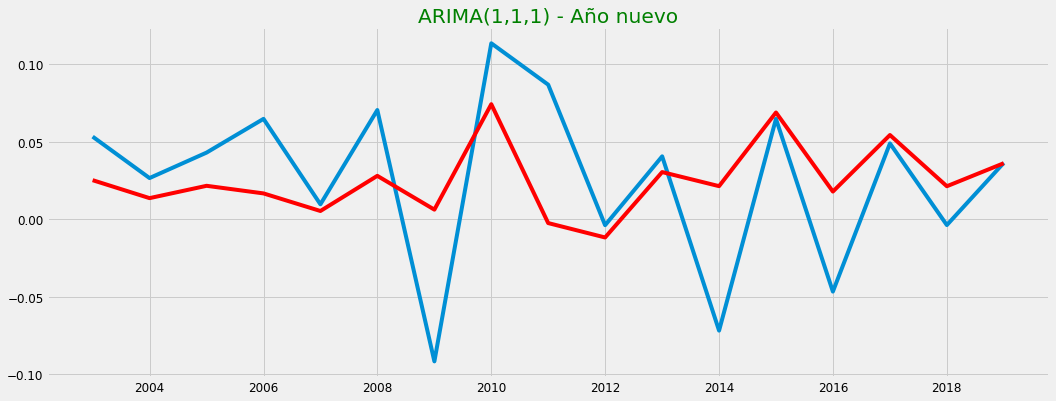

In [208]:
df = a_nuevo['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(0,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(1,1,1) - Año nuevo')

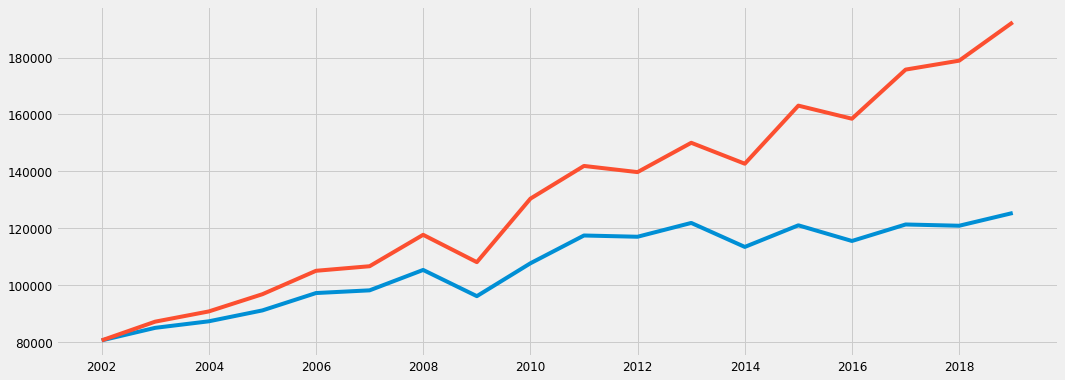

In [197]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

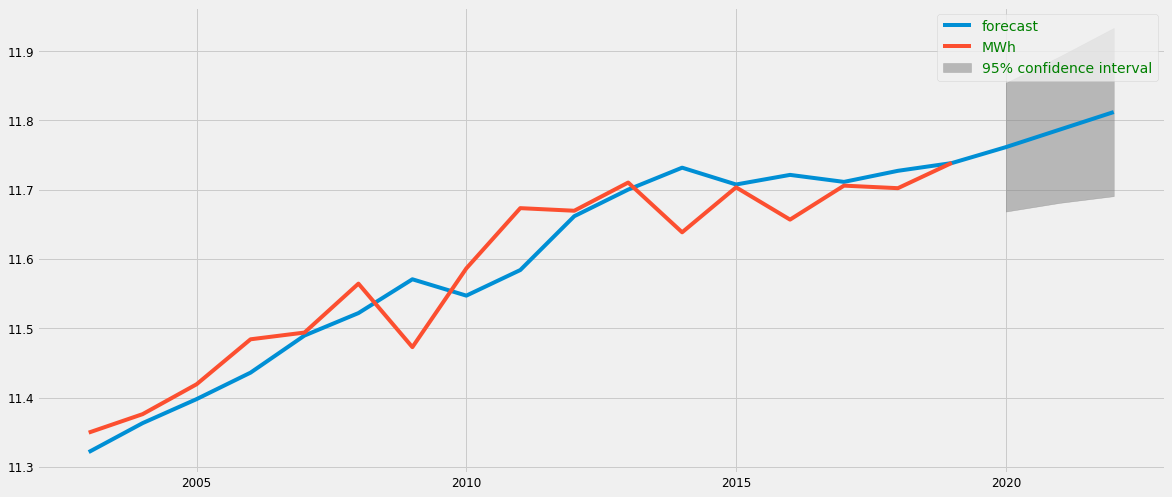

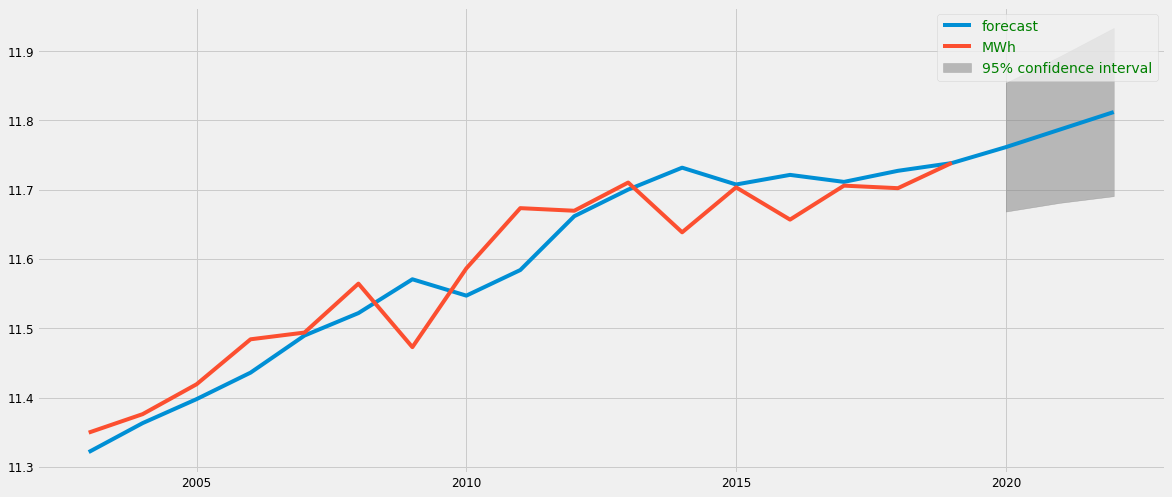

In [182]:
results.plot_predict(1,20)

#### <p style="text-align: center">  <font color = 'red'> Aniversario de la Constitución de 1917

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

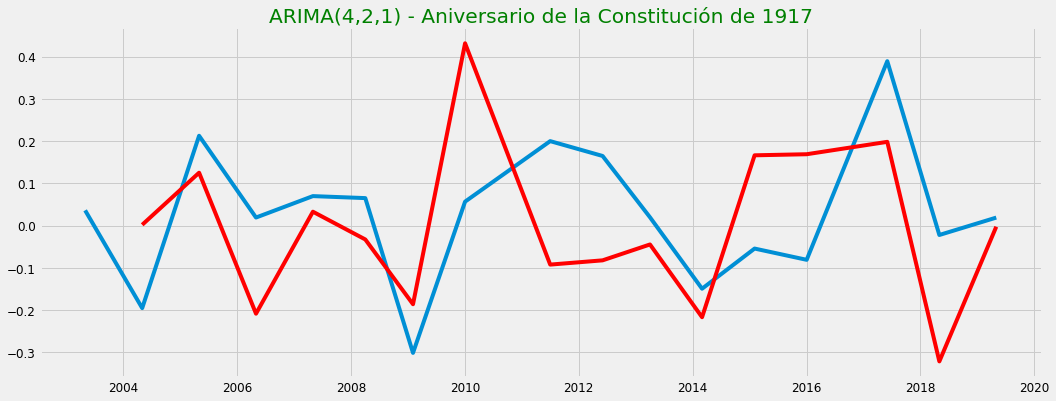

In [251]:
df = a_const['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq = 1) 
model = ARIMA(df_log, order=(4,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

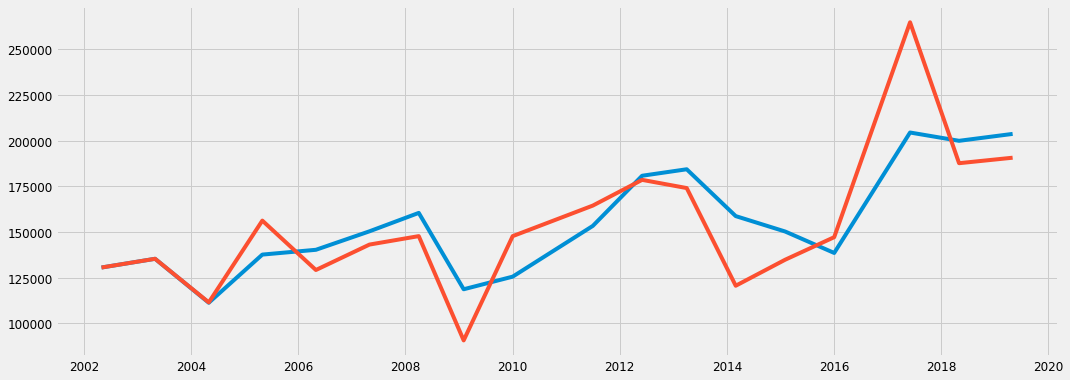

In [252]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

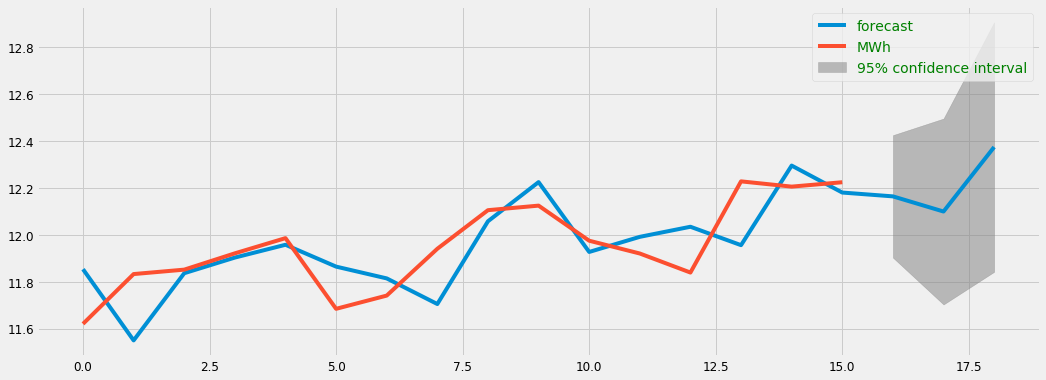

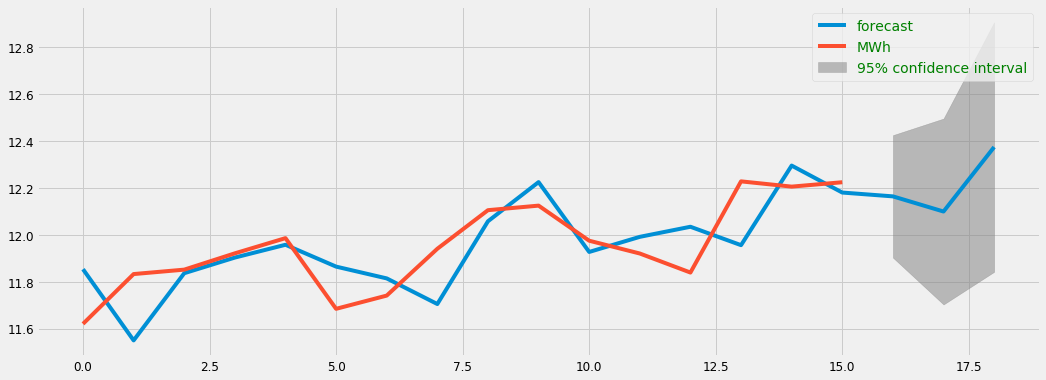

In [255]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Natalicio de Benito Juárez Garcia

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

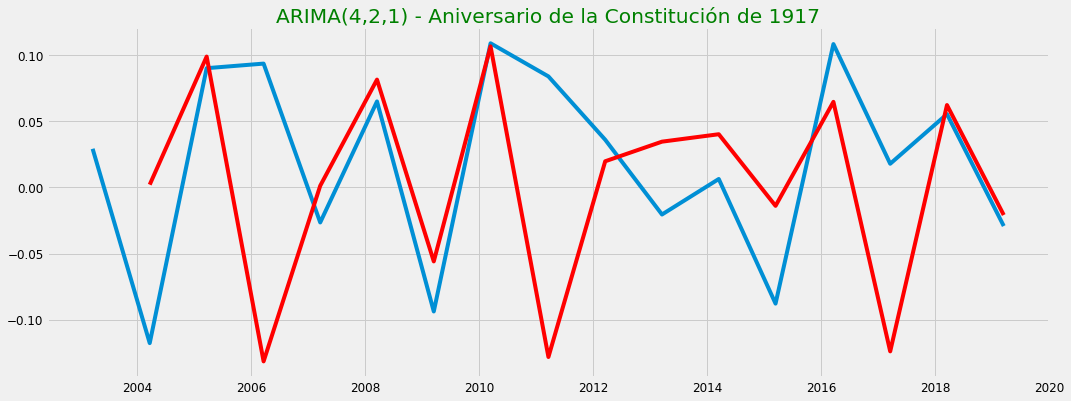

In [260]:
df = nat_bj['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq = 1) 
model = ARIMA(df_log, order=(1,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

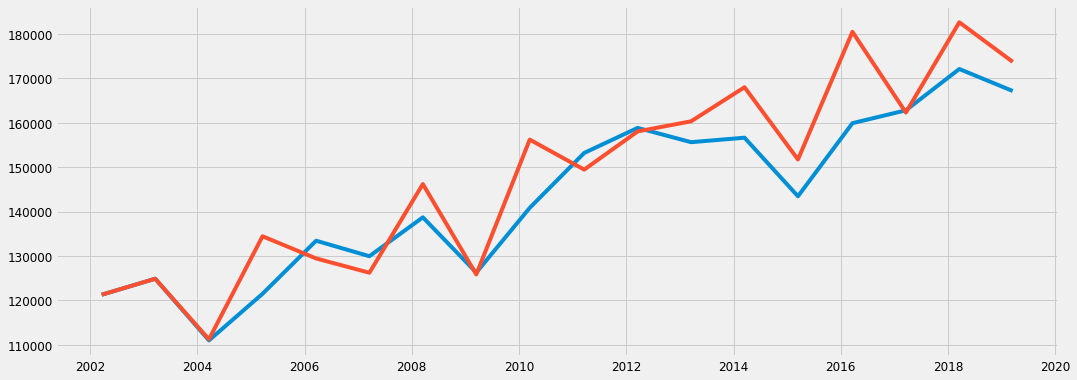

In [261]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

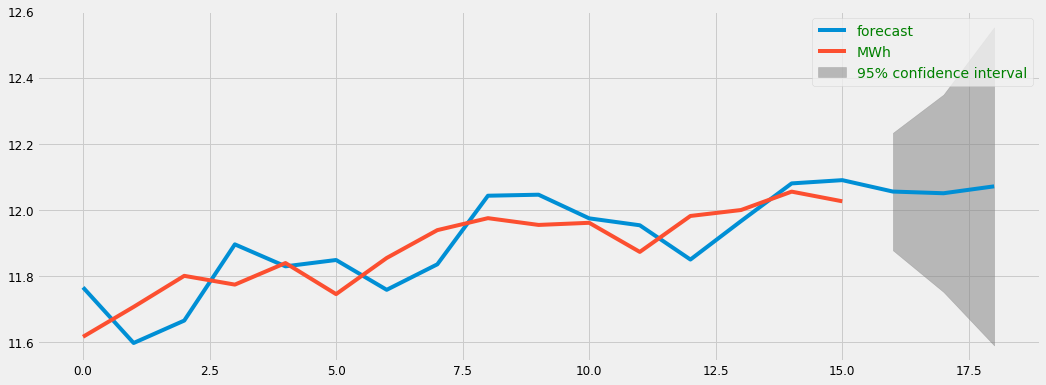

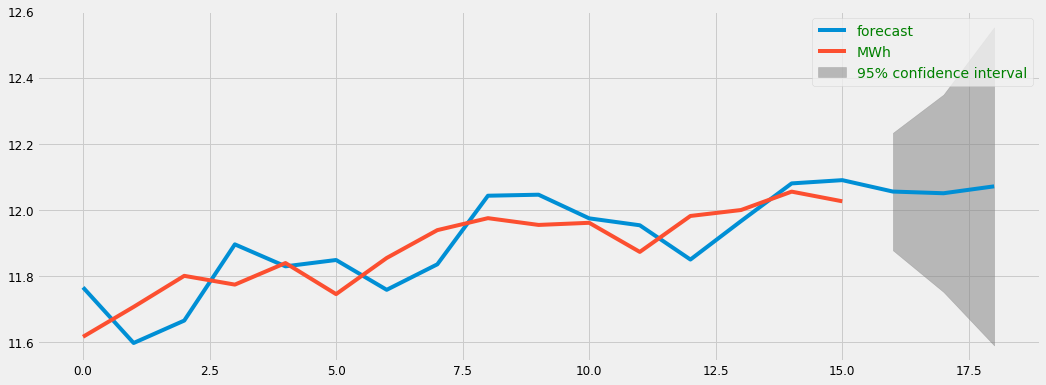

In [265]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Jueves Santo

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

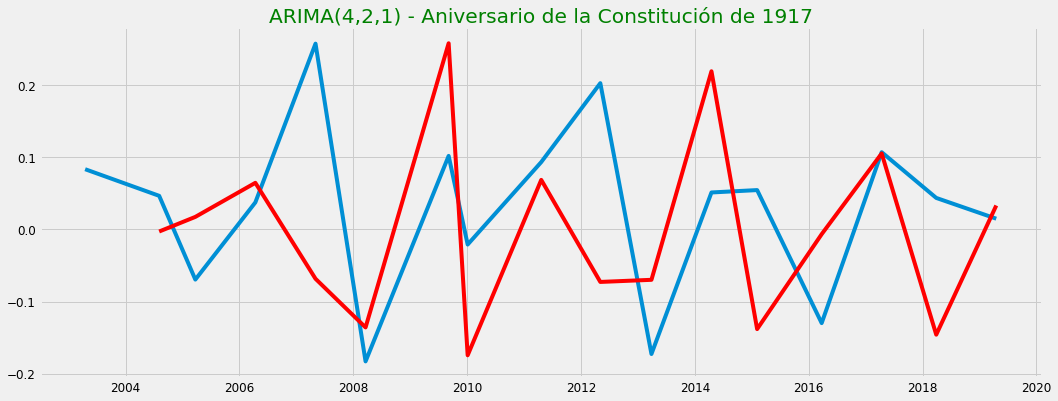

In [272]:
df = js['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq =1) 
model = ARIMA(df_log, order=(1,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

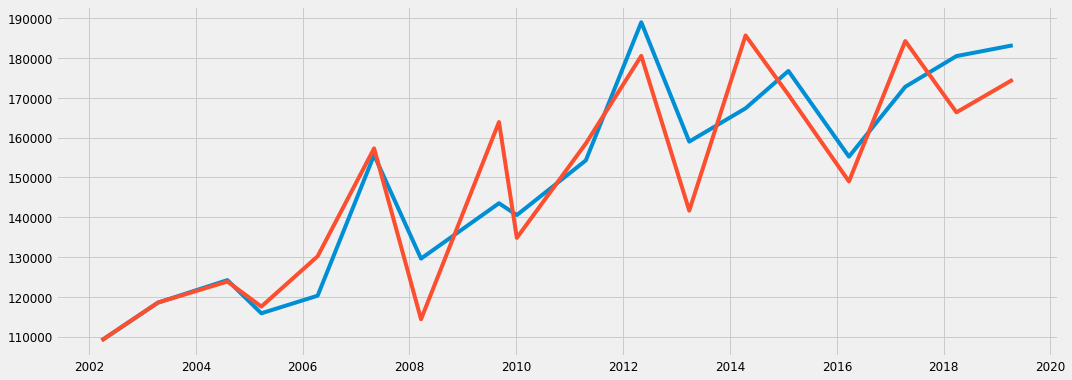

In [273]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

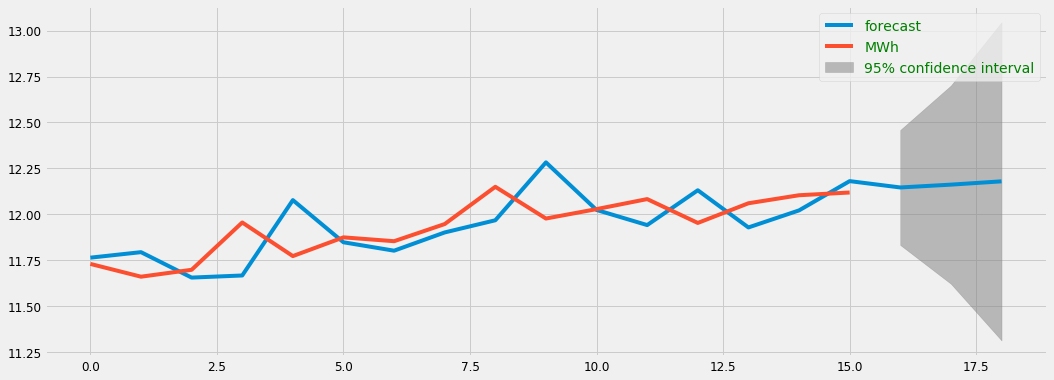

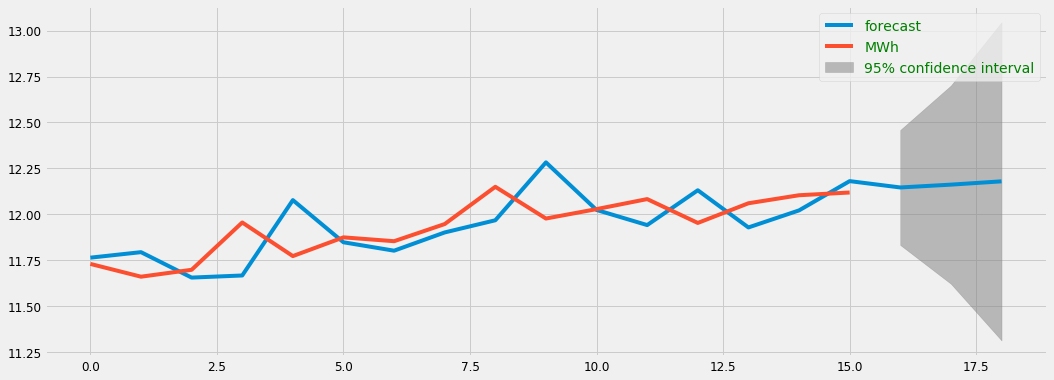

In [274]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Viernes Santo

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

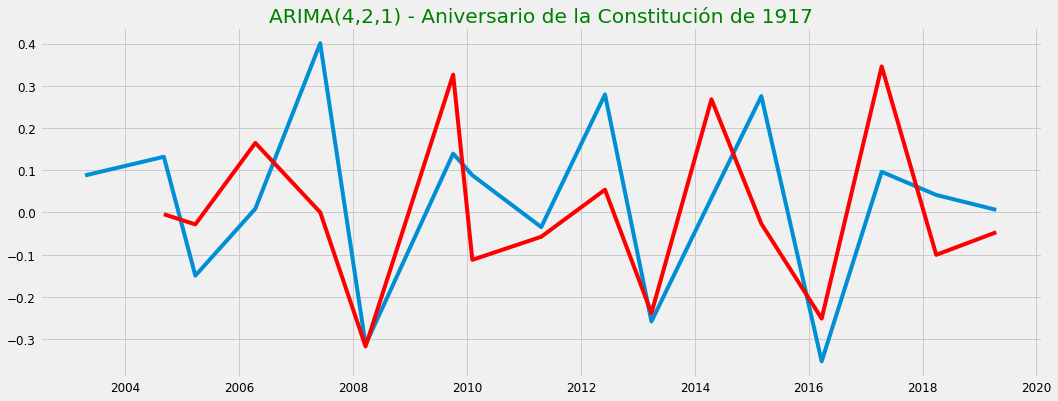

In [280]:
df = vs['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq = 1) 
model = ARIMA(df_log, order=(0,2,1))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

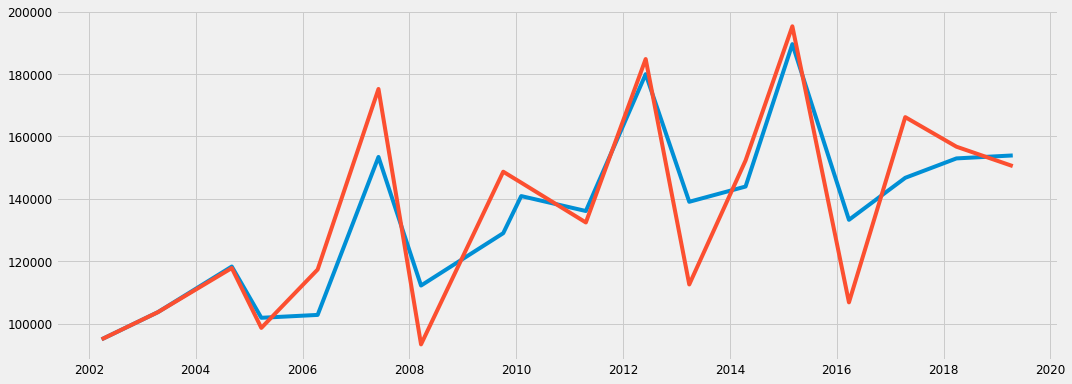

In [281]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

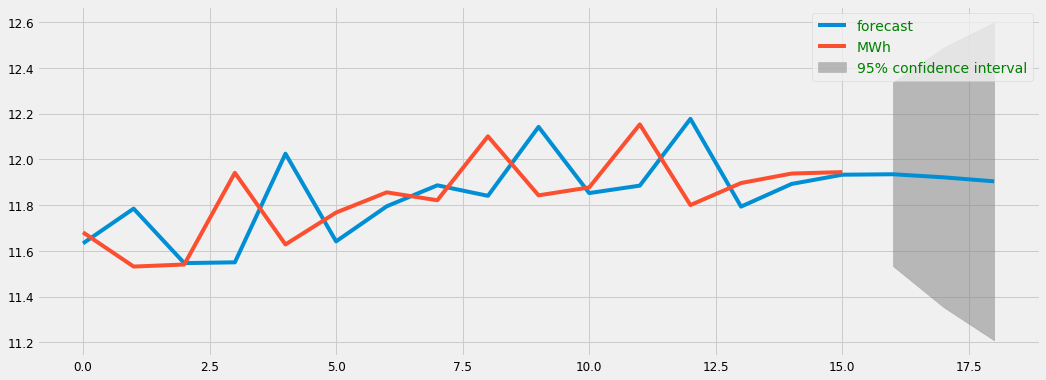

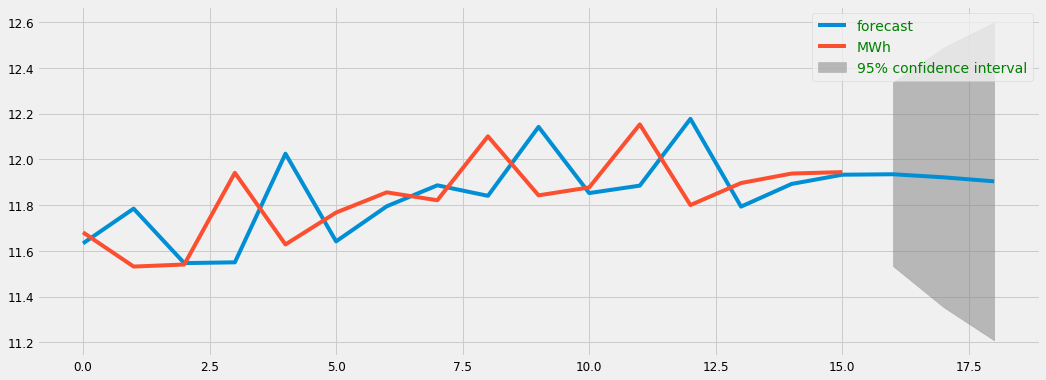

In [282]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Dia del Trabajo

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

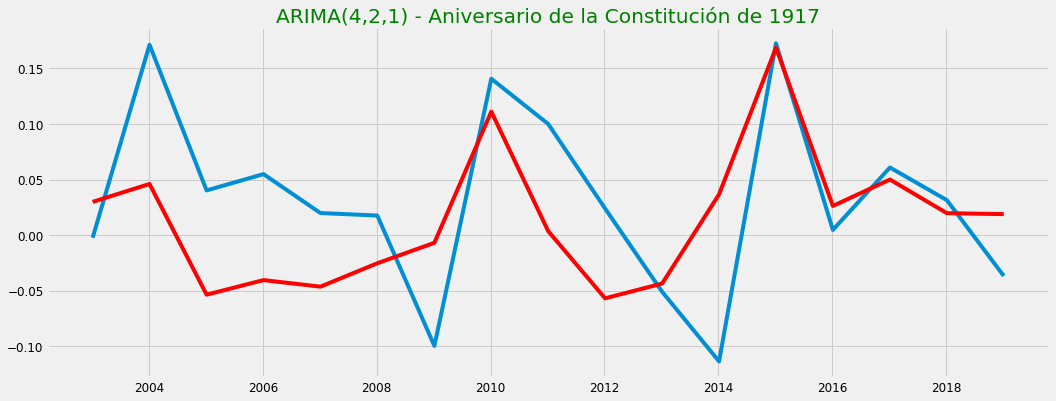

In [289]:
df = dt['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq = 1) 
model = ARIMA(df_log, order=(0,1,1))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

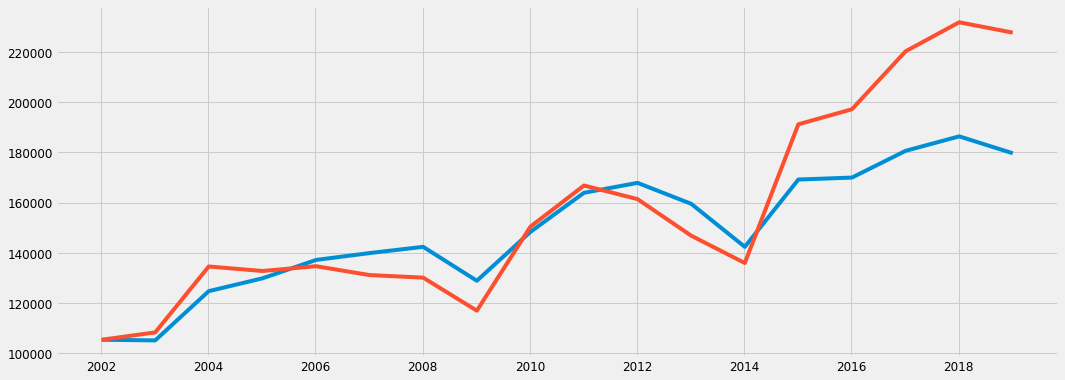

In [290]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

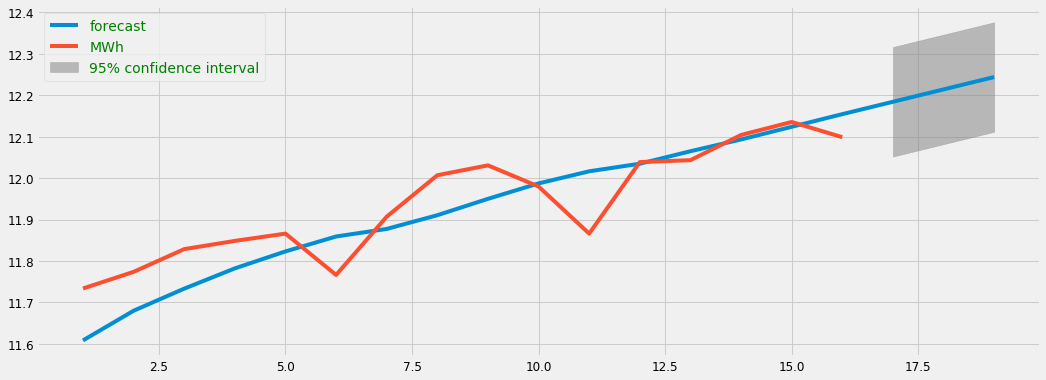

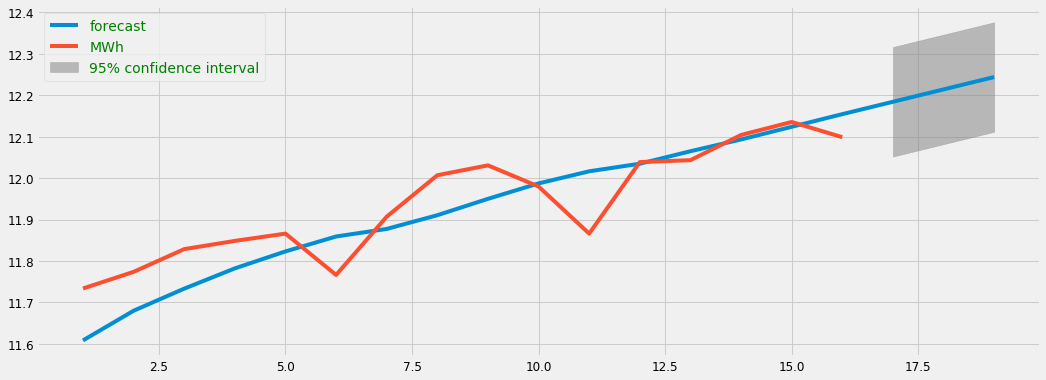

In [291]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Día de la madre

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

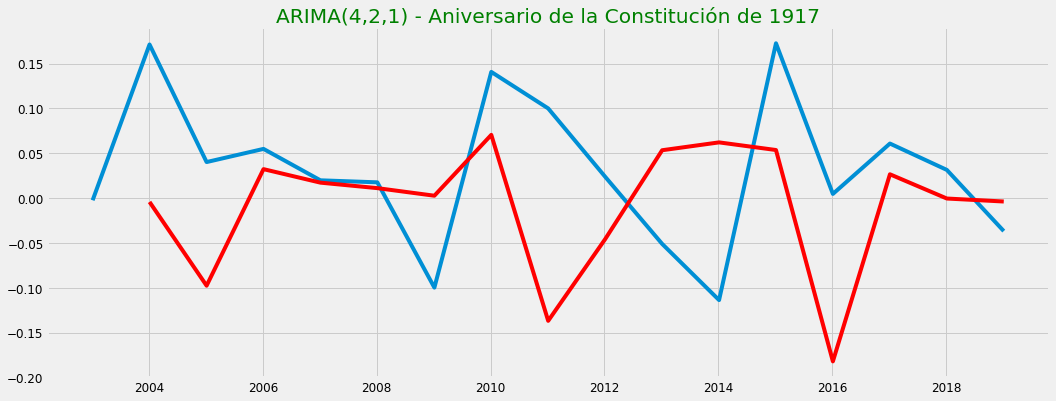

In [307]:
df = dt['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(2,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

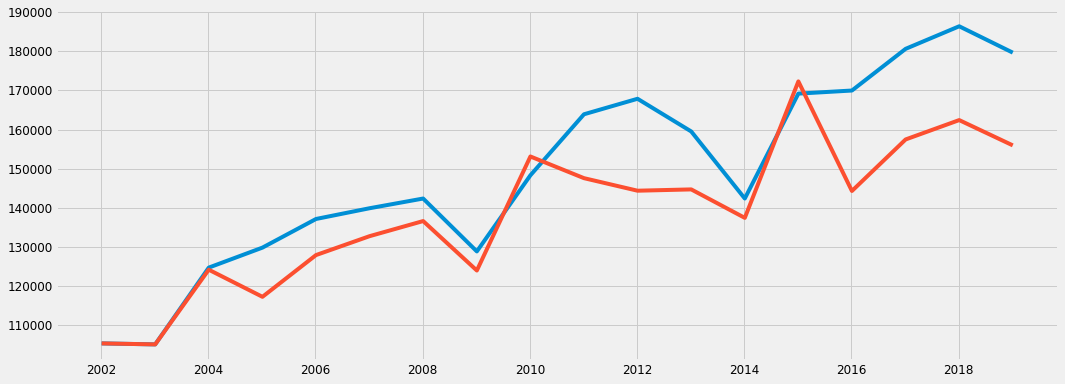

In [308]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

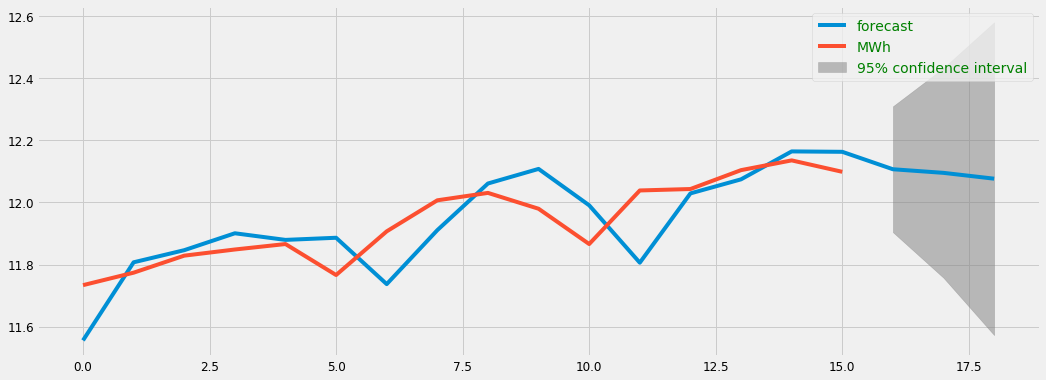

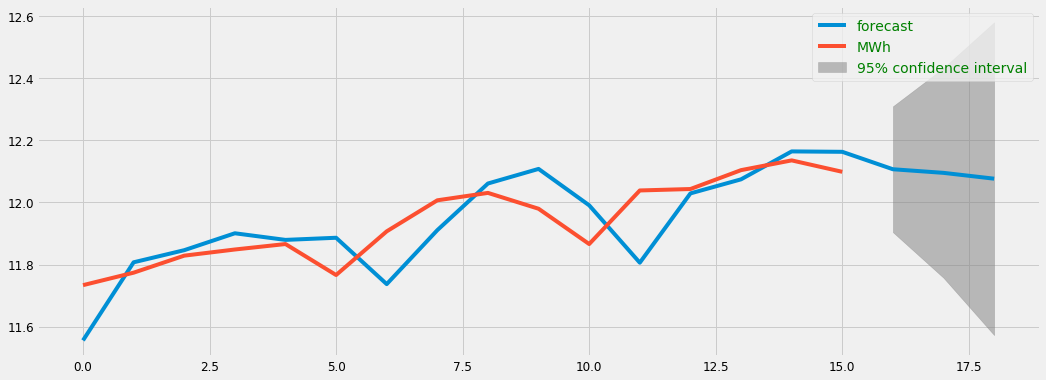

In [309]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Día de la Independencia

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

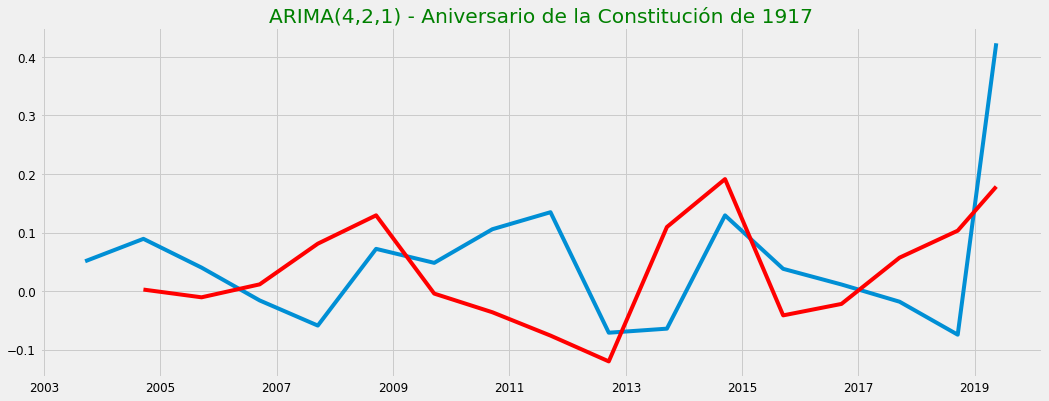

In [372]:
df = d_ind['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(2,2,1))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

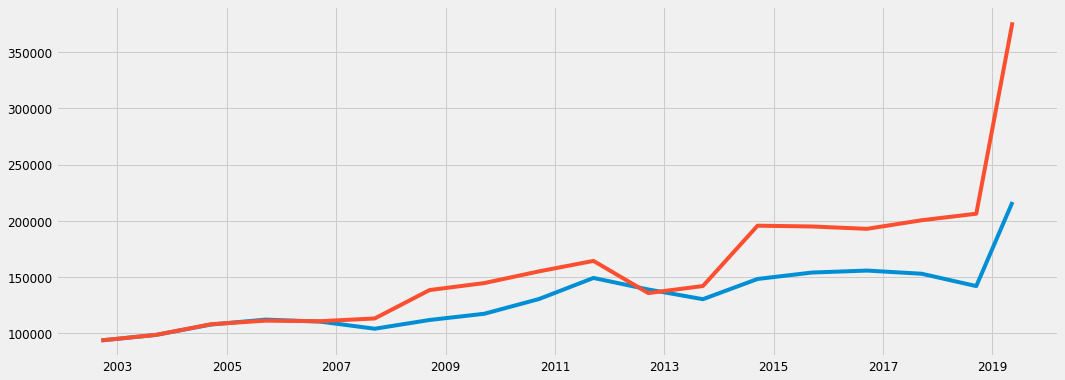

In [373]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

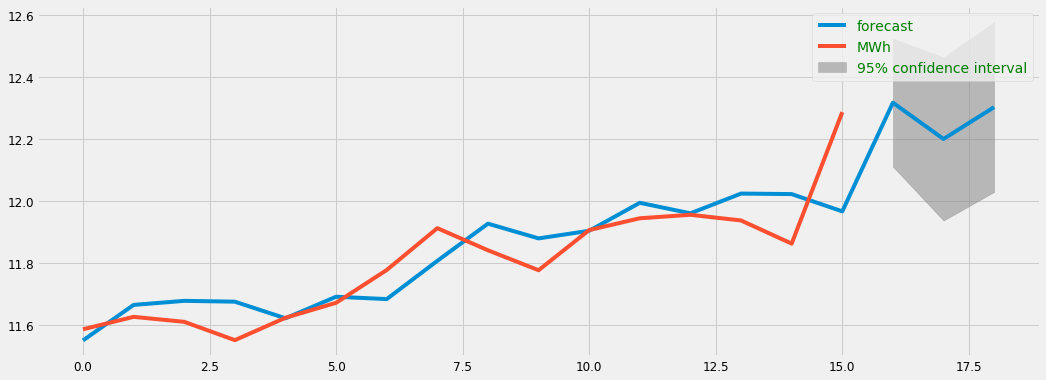

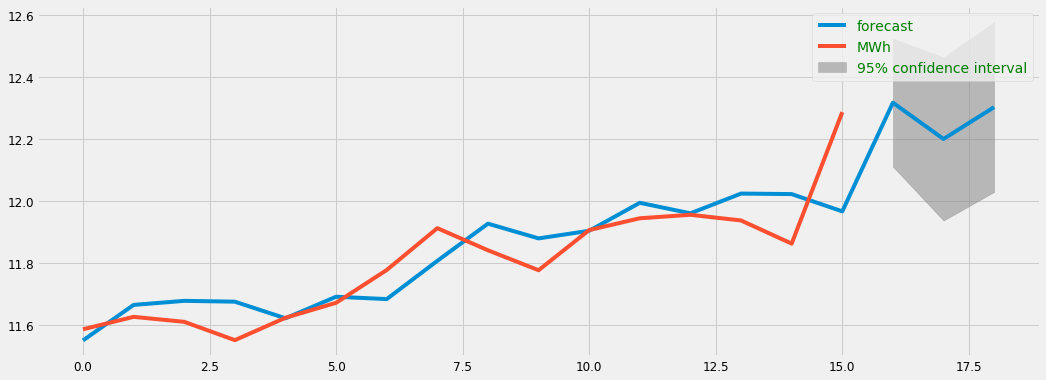

In [374]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Zapopan

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

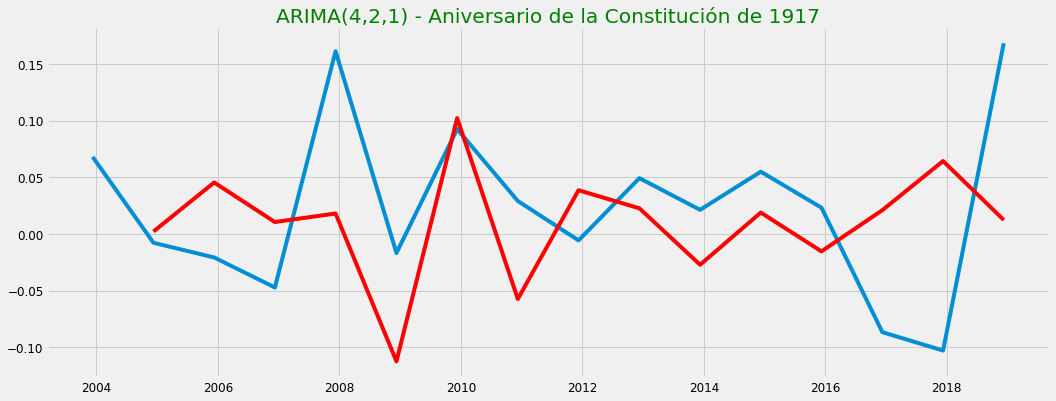

In [375]:
df = d_vz['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(1,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

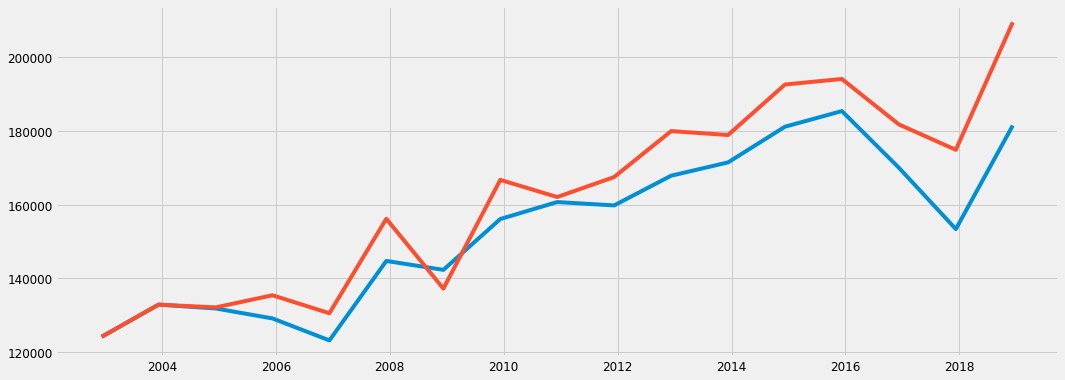

In [376]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

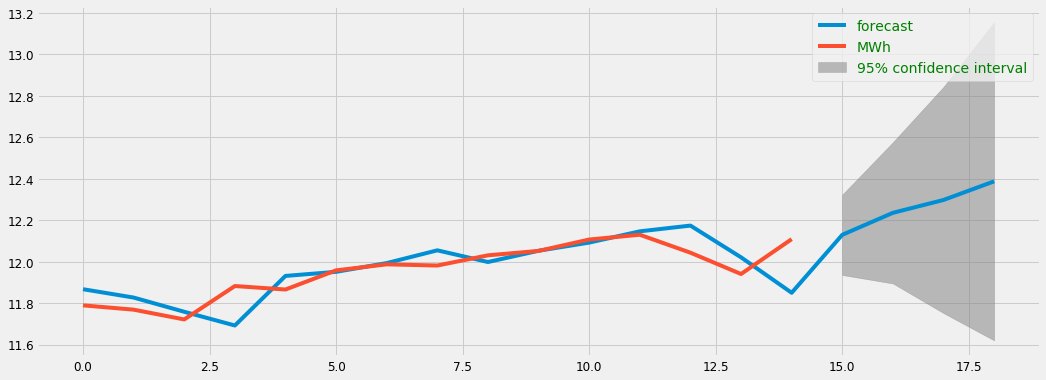

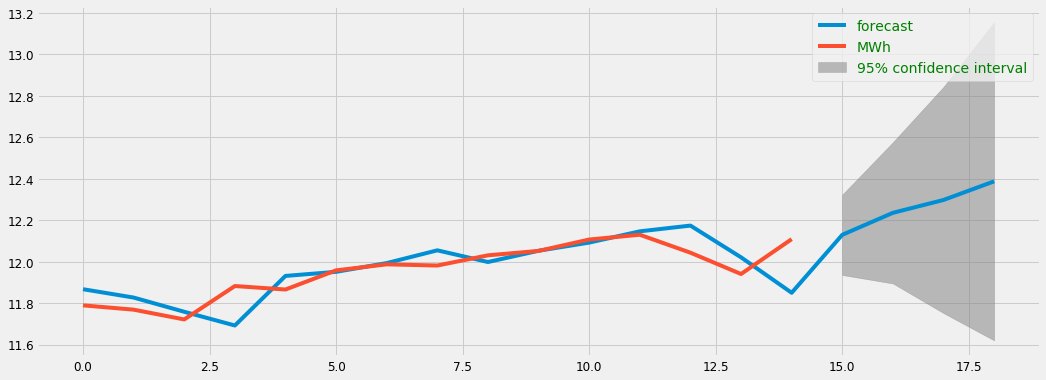

In [377]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Día de los muertos

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

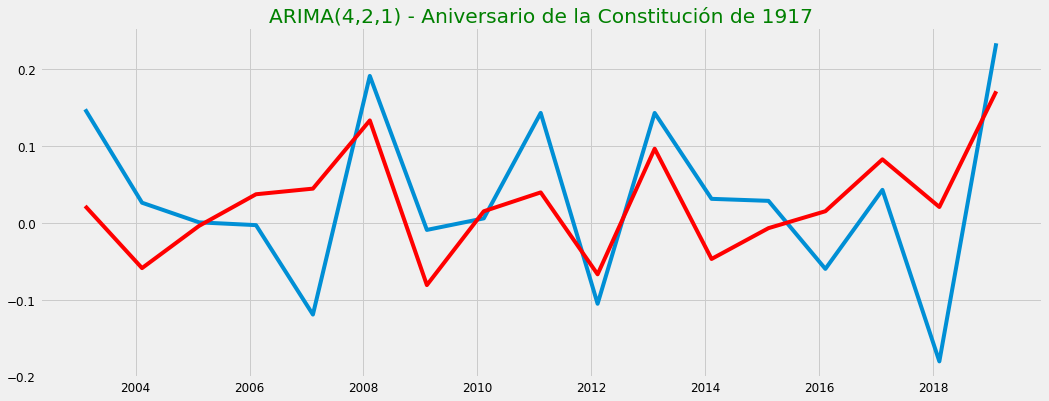

In [378]:
df = d_muer['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(2,1,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

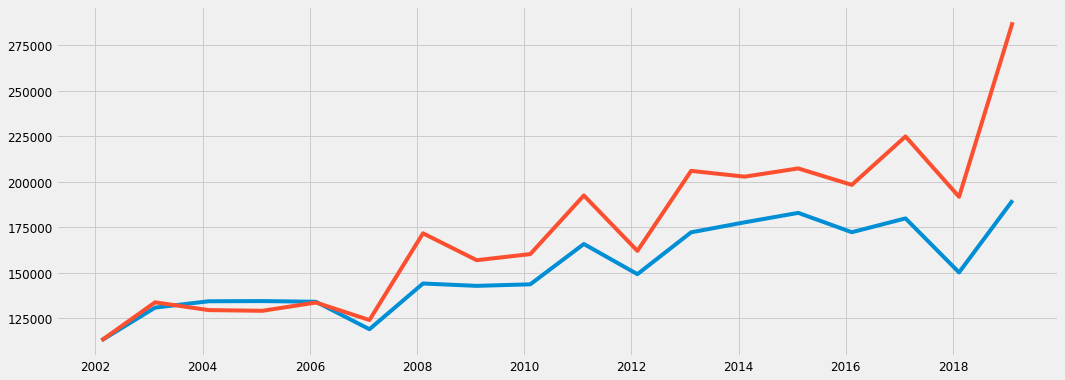

In [379]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

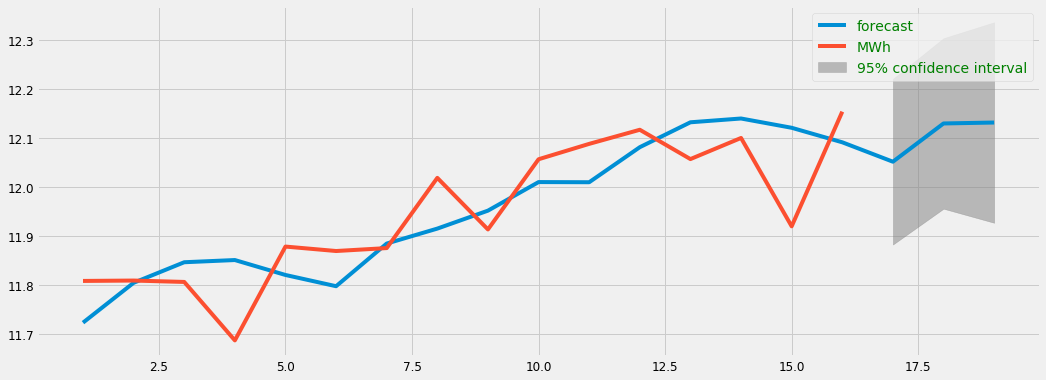

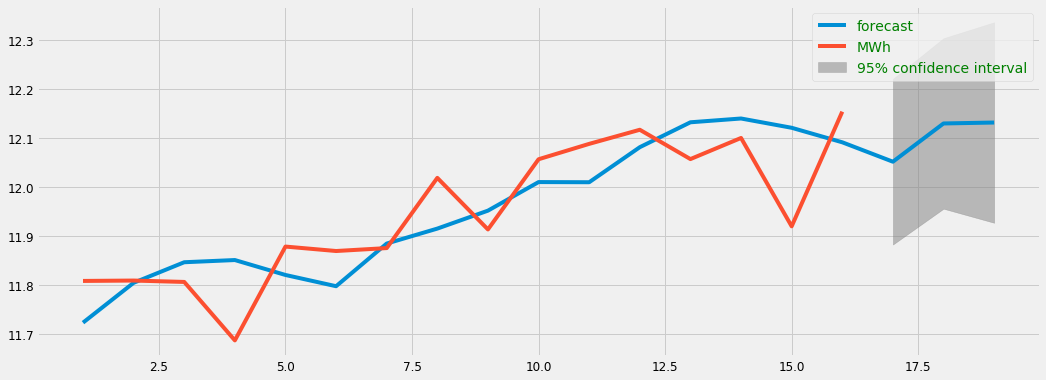

In [380]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Día de la Revolución

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

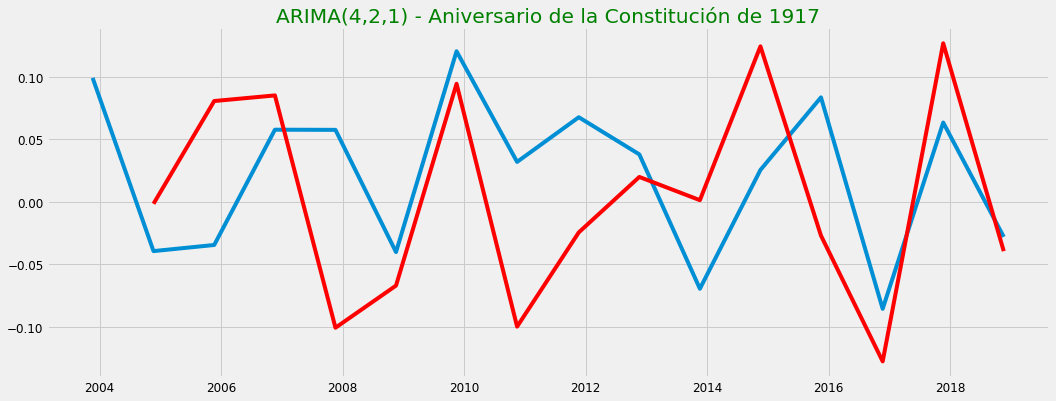

In [381]:
df = d_rev['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(2,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

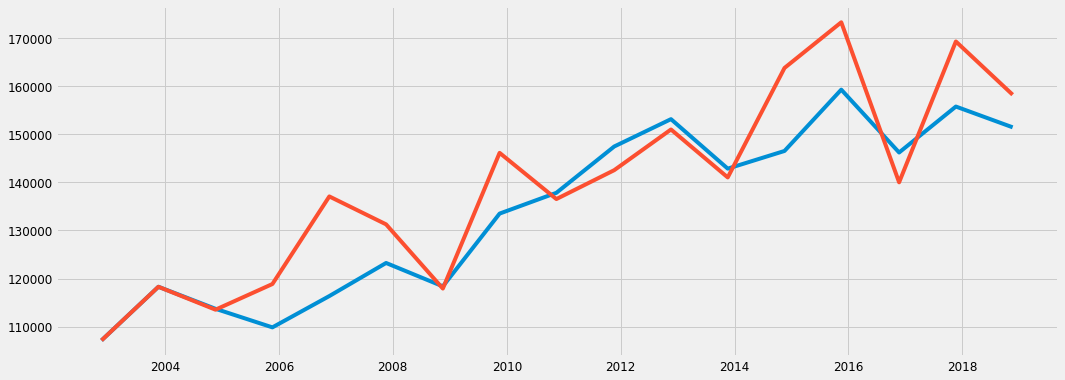

In [382]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

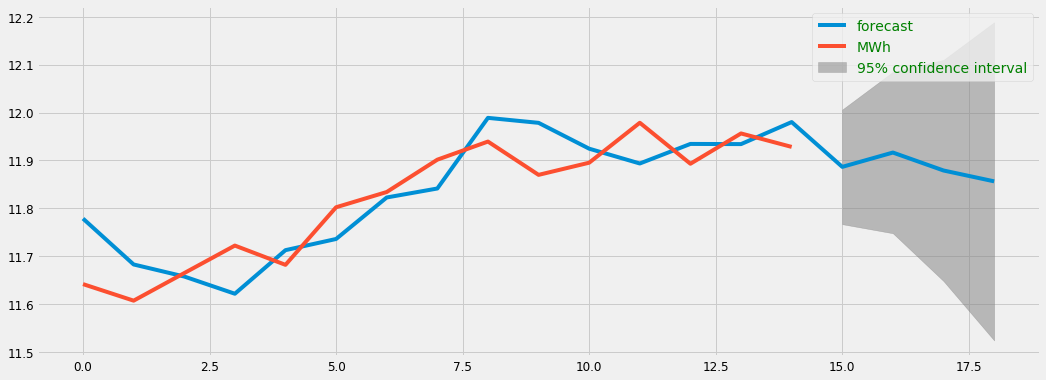

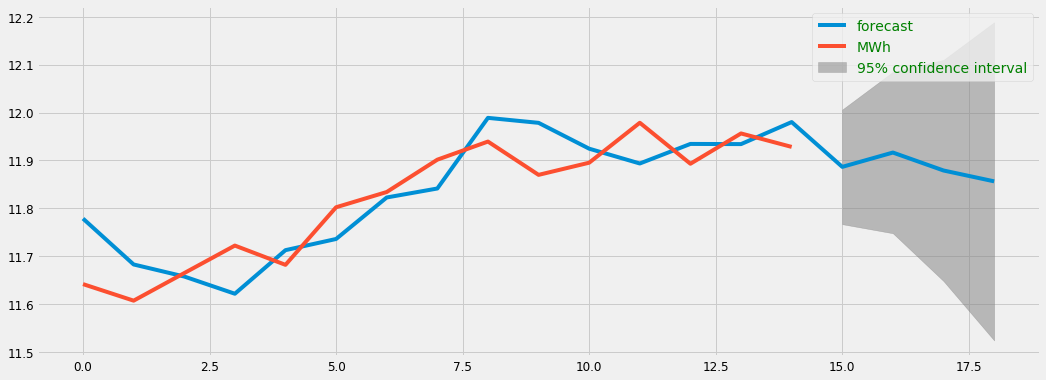

In [383]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Guadalupe

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

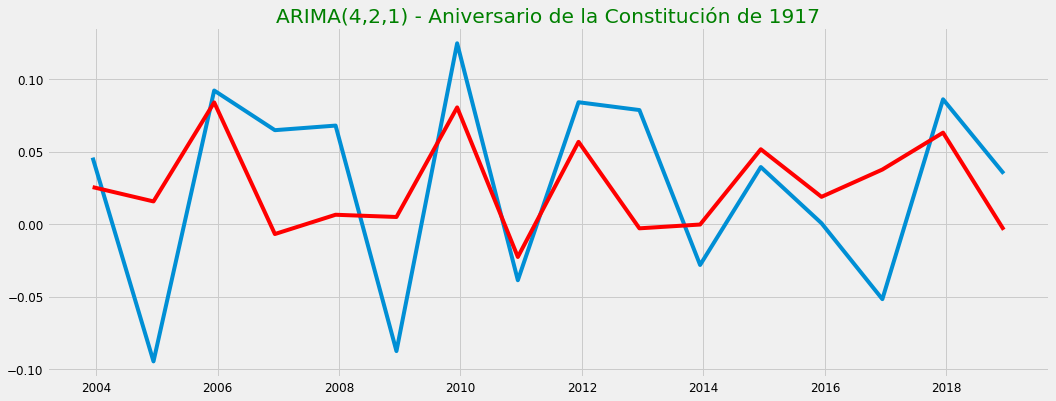

In [384]:
df = d_vg['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(1,1,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

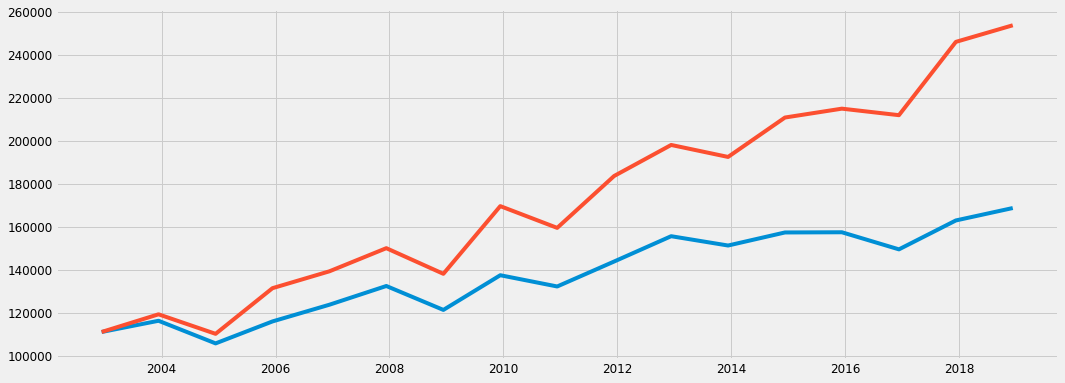

In [385]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

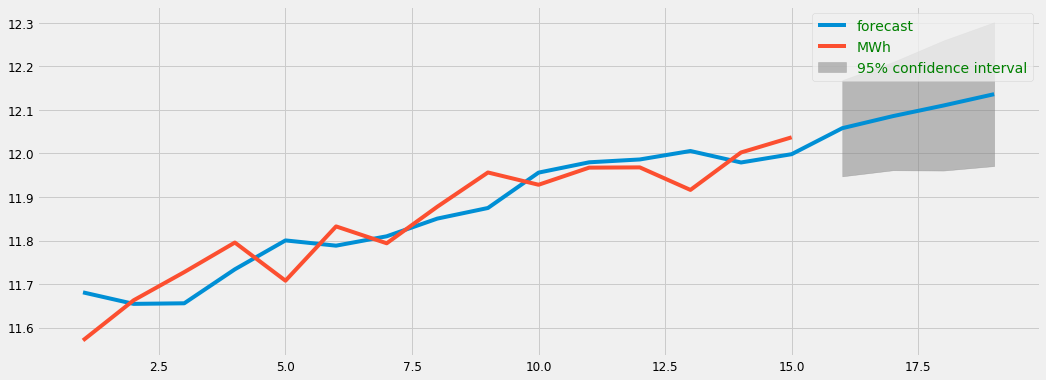

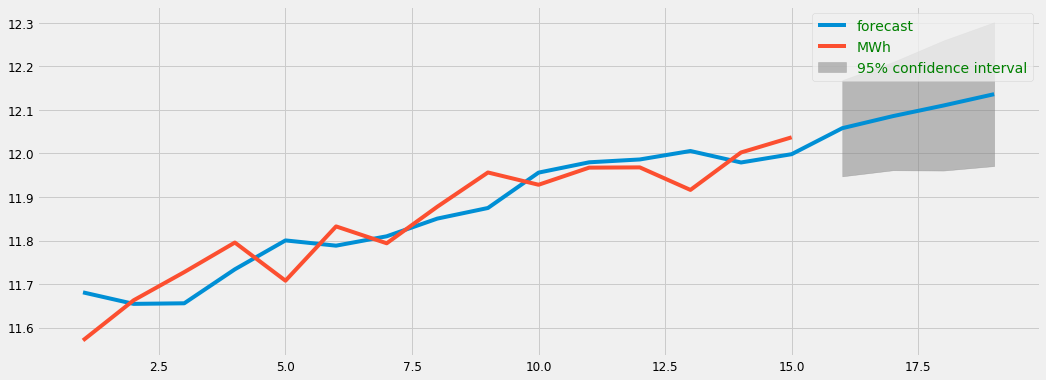

In [386]:
results.plot_predict(2,20)

#### <p style="text-align: center">  <font color = 'red'> Navidad

Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

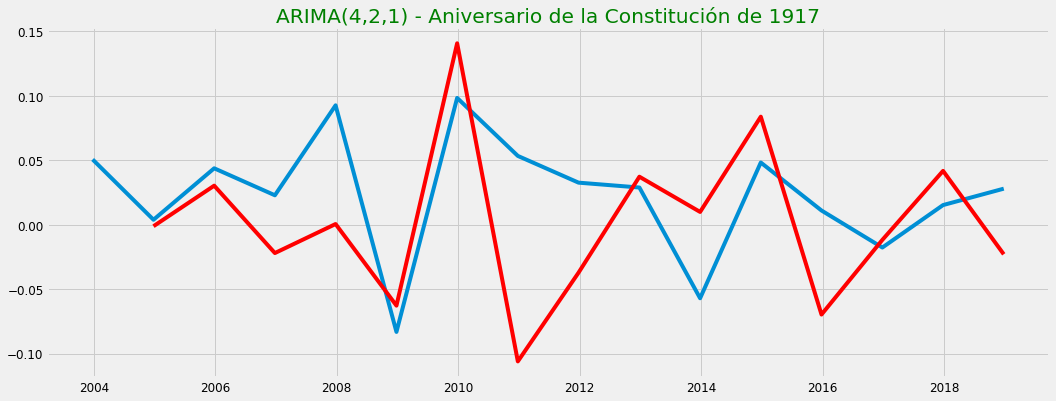

In [387]:
df = nav['MWh'].astype(float)
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(2,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

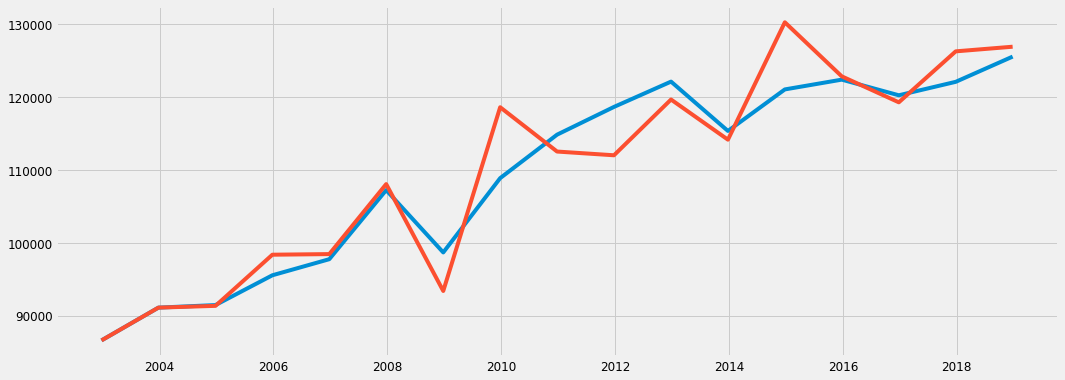

In [388]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

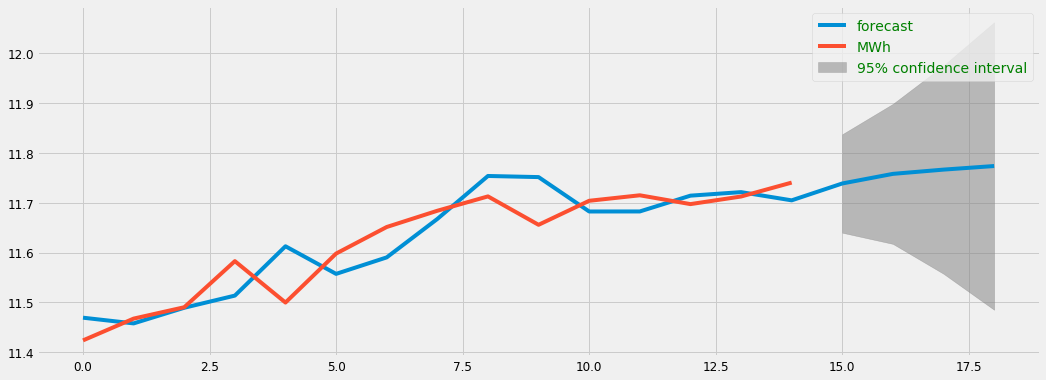

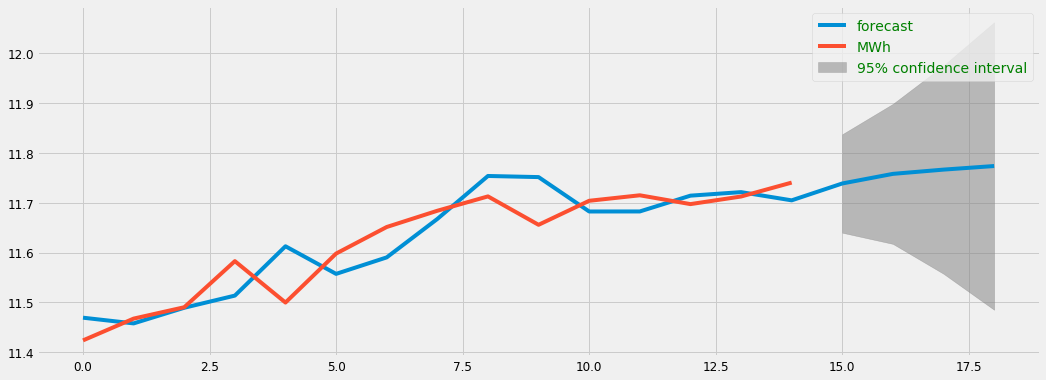

In [389]:
results.plot_predict(2,20)

# <p style="text-align: center">  <font color = 'darkblue'> Tercera Parte
### <p style="text-align: center">  <font color = 'black'> Errores

In [283]:
# Proyecciones

p = pd.DataFrame(columns = names)

